# Задача 1. Линейная регрессия, метод градиентного спуска

Задачу выполнил Степырев Даниил, студент 22.М-05мм группы.

## Данные, на которых решается задача

В задаче используется датасет электрических машин (ссылка).
Описание датасета:
- **Brand** --- марка автомобиля
- **Model** --- название модели автомобиля
- **Accel** --- время ускорения автомобиля 0-100 км/ч в секундах
- **TopSpeed** --- максимальная скорость в км/ч
- **Range** --- запас хода в километрах
- **Efficiency** --- эффективность (?)
- **FastCharge** --- скорость зарядки автомобиля: число добавленных километров в час
- **RapidCharge** --- возможность быстрой зарядки
- **PowerTrain** --- привод автомобиля
- **PlugType** --- тип зарядки
- **BodyStyle** --- тип кузова
- **Segment** --- класс автомобиля
- **Seats** --- количество пассажирских мест
- **PriceEuro** --- цена в евро

## Считывание данных

Подключаем используемые библиотеки:

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Считываем обучающую выборку:

In [2]:
df = pd.read_csv('Dataset/electric-cars.csv')
df.head()

,Brand,Model,Accel,TopSpeed,Range,Efficiency,FastCharge,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6 sec,233 km/h,450 km,161 Wh/km,940 km/h,Rapid charging possible,All Wheel Drive,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID.3 Pure,10.0 sec,160 km/h,270 km,167 Wh/km,250 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7 sec,210 km/h,400 km,181 Wh/km,620 km/h,Rapid charging possible,All Wheel Drive,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8 sec,180 km/h,360 km,206 Wh/km,560 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5 sec,145 km/h,170 km,168 Wh/km,190 km/h,Rapid charging possible,Rear Wheel Drive,Type 2 CCS,Hatchback,B,4,32997


Общее количество пропущенных значений:

In [3]:
df.isnull().sum()

Brand          0
Model          0
Accel          0
TopSpeed       0
Range          0
Efficiency     0
FastCharge     0
RapidCharge    0
PowerTrain     0
PlugType       0
BodyStyle      0
Segment        0
Seats          0
PriceEuro      0
dtype: int64

Все признаки имеют заполненные значения значения.

Рассмотрим, какого тип признаков проставлен в датасете по умолчанию:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Brand        103 non-null    object
 1   Model        103 non-null    object
 2   Accel        103 non-null    object
 3   TopSpeed     103 non-null    object
 4   Range        103 non-null    object
 5   Efficiency   103 non-null    object
 6   FastCharge   103 non-null    object
 7   RapidCharge  103 non-null    object
 8   PowerTrain   103 non-null    object
 9   PlugType     103 non-null    object
 10  BodyStyle    103 non-null    object
 11  Segment      103 non-null    object
 12  Seats        103 non-null    int64 
 13  PriceEuro    103 non-null    int64 
dtypes: int64(2), object(12)
memory usage: 11.4+ KB


Рассмотрим статистику по целевому признаку **PriceEuro**: сколько и каких значений он принимает. Воспользуемся функцией value_counts(): 

In [5]:
df['PriceEuro'].value_counts()

45000    6
50000    3
29234    2
30000    2
36837    2
        ..
38105    1
67358    1
34361    1
38017    1
62000    1
Name: PriceEuro, Length: 87, dtype: int64

Видим, что **PriceEuro** принимает 87 различных значений. Посчитаем минимальную, максимальную и среднюю цену:

In [6]:
df['PriceEuro'].min()

20129

In [7]:
df['PriceEuro'].max()

215000

In [8]:
df['PriceEuro'].mean()

55811.5631

Выяснили, что поле **PriceEuro** принимает значения от 20129 до 215000. Средняя цена электромобиля: 55811.

## Первичный анализ данных

### Признак Brand

Выясним, какой тип имеет признак **Марка** в датасете:

In [9]:
df['Brand'].describe()

count        103
unique        33
top       Tesla 
freq          13
Name: Brand, dtype: object

Видим, что признак **Марка** принимает 33 уникальных значения. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только строковые значения. Уточним тип этого признака:

In [10]:
df['Brand'] = df['Brand'].astype('|S').apply(lambda s: s.strip()).str.decode('utf-8')
df['Brand'].describe()

count       103
unique       33
top       Tesla
freq         13
Name: Brand, dtype: object

Выясним, сколько электрических автомобилей доступно у определённой **марки**. Отобразим эти значения на графике:

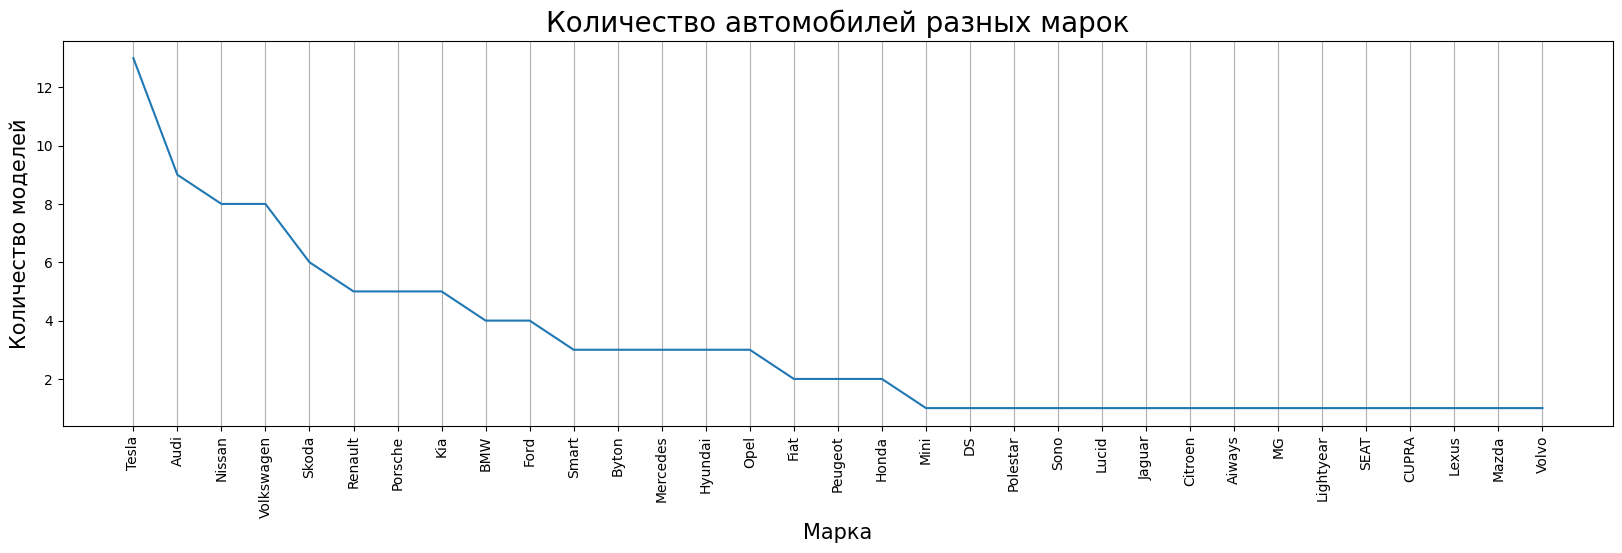

In [11]:
plt.figure(figsize=(20,5))
plt.grid(axis="x")
plt.xticks(rotation = 90)
plt.title('Количество автомобилей разных марок', fontsize = 20)
plt.xlabel('Марка', fontsize= 15)
plt.ylabel('Количество моделей', fontsize= 15)
plt.plot(df["Brand"].value_counts())
plt.show()

Видим, что в датасете представлено больше всего электромобилей марки *Tesla*, *Audi* и *Nissan*. Марки *Mini*, *DS*, *Polestar*, *Sono*, *Lucid*, *Jaguar*, *Citroern*, *Aiways*, *MG*, *Lightyear*, *SEAT*, *CUPRA*, *Lexus*, *Mazda*, *Volvo* имеют в датасете всего по одной представленной модели.

Заведём функцию, которая поможет рисовать графики:

In [12]:
def show_barplot(x_param_name, y_param_name = "PriceEuro"):
    plt.figure(figsize=(20,5))
    plt.grid(axis="x")
    plt.xticks(rotation = 90)
    plt.title(y_param_name + ' vs ' + x_param_name, fontsize = 20)
    plt.xlabel(x_param_name, fontsize= 15)
    plt.ylabel(y_param_name, fontsize= 15)
    sns.barplot(x = df[x_param_name], y = df[y_param_name])
    plt.show()

Посмотрим график стоимости автомобиля *PriceEuro* в зависимости от марки:

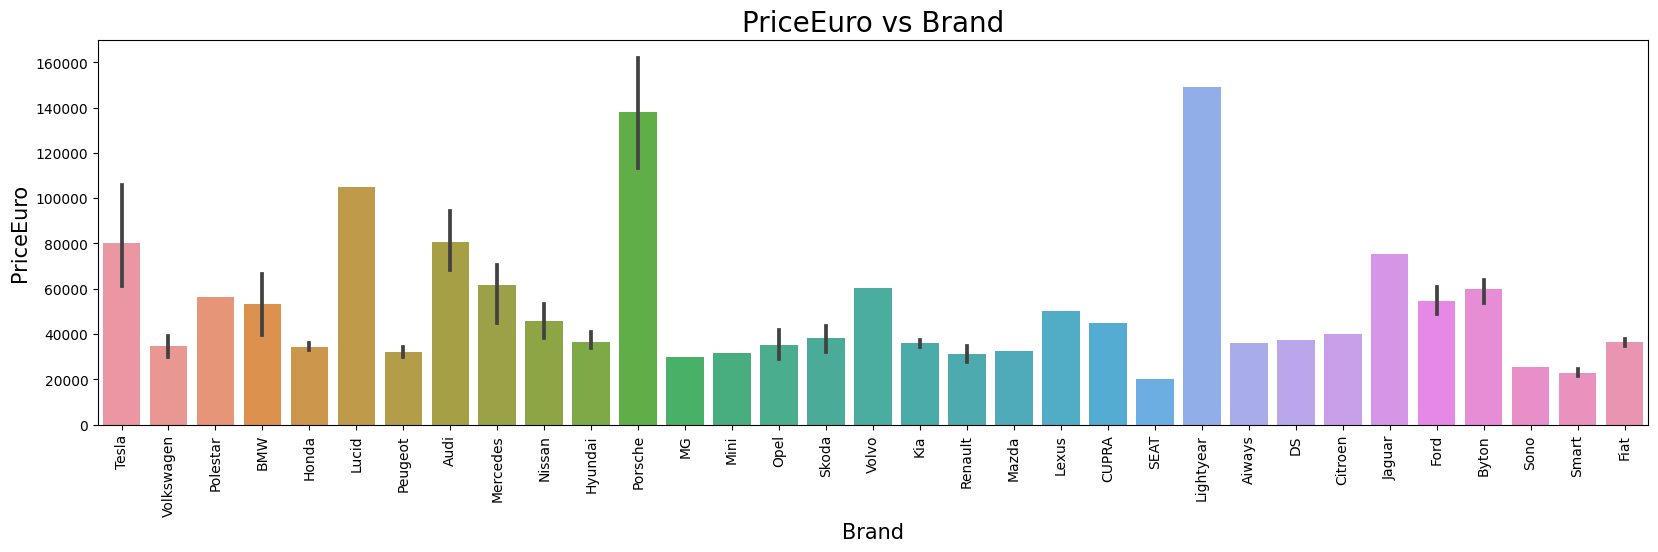

In [13]:
show_barplot("Brand", "PriceEuro")

Из графика видно, что большинство автомобилей в датасете стоят от 40000 до 60000 евро. Самые дорогие автомобили у марок *Porsche* и *Lightyear*, а самые бюджетные у *SEAT* и *Smart*.

### Признак Model

Выясним, сколько стоят автомобиля определённой **модели**. Отобразим эти значения на графике:

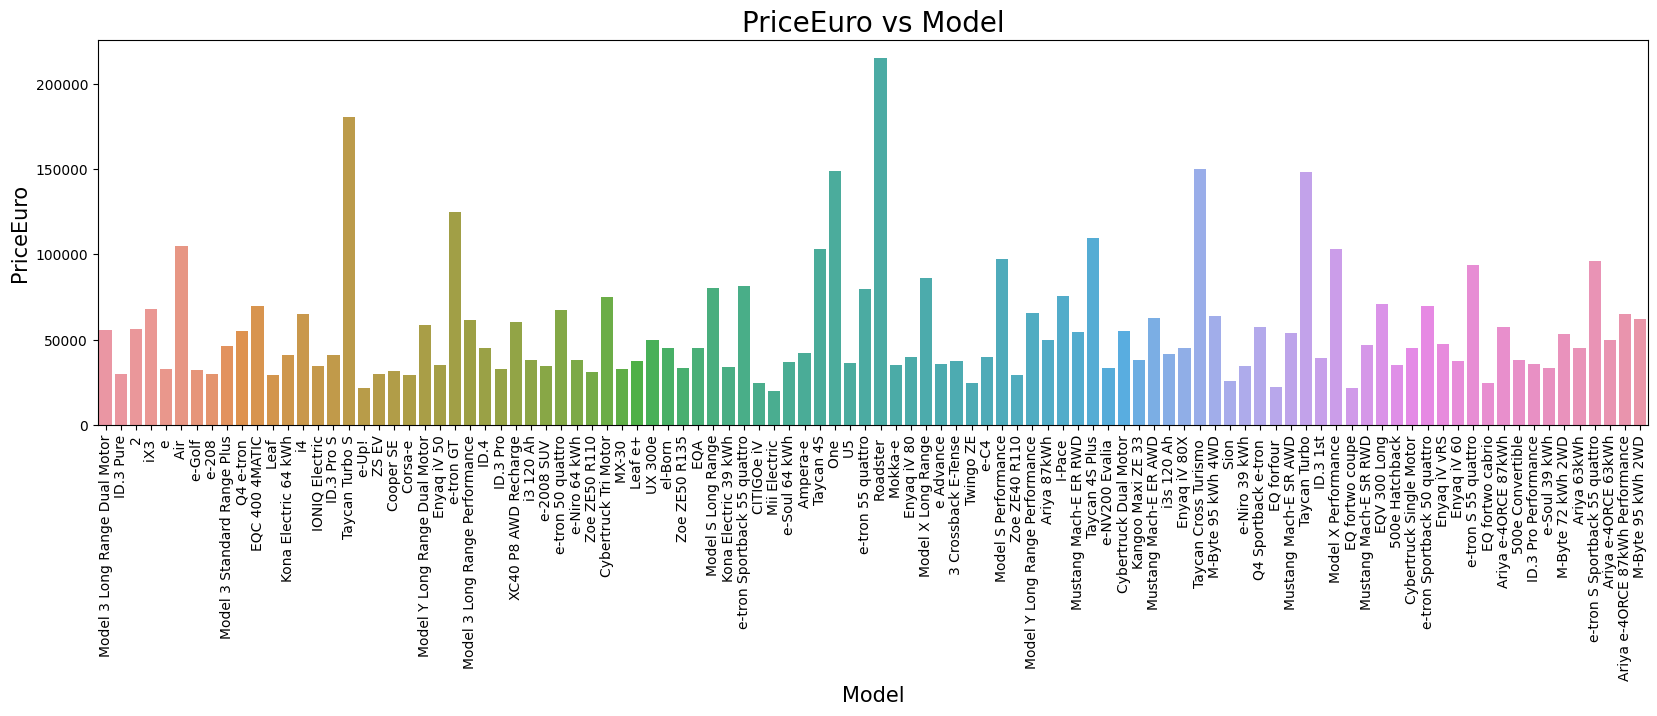

In [14]:
show_barplot("Model", "PriceEuro")

Видим более подробное график цен автомобилей и их стоимости. Из графика видно, что электических автомобили можно разделить по стоимости на две группы: дешевле 50000 евро и дороже 50000 евро.

Также можно заметить, что признак **Model** и признак **Brand** имеют много уникальных значений. На ценообразование машины может влиять страна, в которой автомобиль был разработан. Для определения страны производителя, напишем небольшую функцию `get_origin_country(brand)`:

In [15]:
def get_origin_country(brand):
    if (brand == "Mercedes" or brand == "Porsche" or brand == "Mini"
       or brand == "Volkswagen" or brand == "BMW" or brand == "Audi"
       or brand == "Opel" or brand == "Sono" or brand == "Smart"):
        return "Germany"
    
    if (brand == "Peugeot" or brand == "Nissan" or brand == "Renault"
       or brand == "DS" or brand == "Citroen"):
        return "France"
    
    if (brand == "Honda" or brand == "Mazda" or brand == "Lexus"):
        return "Japan"
    
    if (brand == "Tesla" or brand == "Lucid" or brand == "Ford"):
        return "USA"
    
    if (brand == "Polestar" or brand == "Volvo"):
        return "Sweden"

    if (brand == "Hyundai" or brand == "Kia"):
        return "Korea"
    
    if (brand == "CUPRA" or brand == "SEAT"):
        return "Spain"
    
    if (brand == "MG" or brand == "Jaguar"):
        return "England"
    
    if (brand == "Aiways" or brand == "Byton"):
        return "China"

    if (brand == "Lightyear"):
        return "Finland"    
    
    if (brand == "Skoda"):
        return "Czech"
    
    if (brand == "Fiat"):
        return "Italy"
    
    return "Other"

Введём новый признак **OriginCountry** и проверим это предположение:

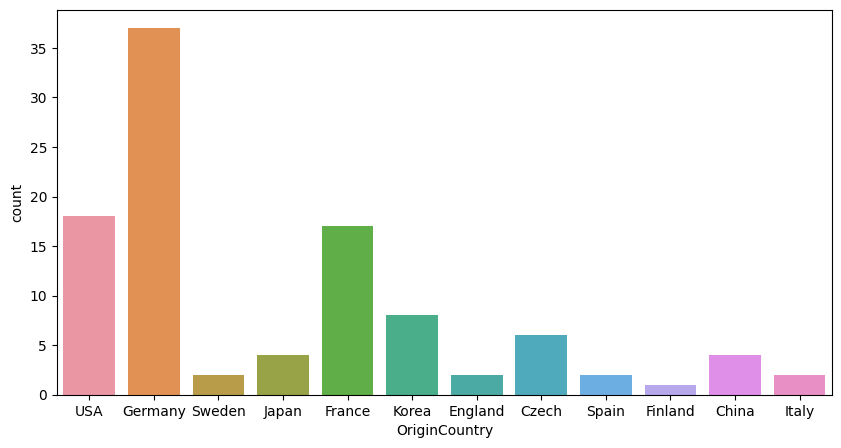

In [16]:
df['OriginCountry'] = df['Brand'].apply(lambda x: get_origin_country(x))
sns.countplot(x=df['OriginCountry'])
fig = plt.gcf()
fig.set_size_inches(10, 5)

Видим, что удалось распределить все автомобили по странам производителям. Больше всего автомобилей имеют страну производителя Германию, США и Францию, меньше всего --- Финляндию.

Рассмотрим график стоимости автомобиля относительно страны производителя:

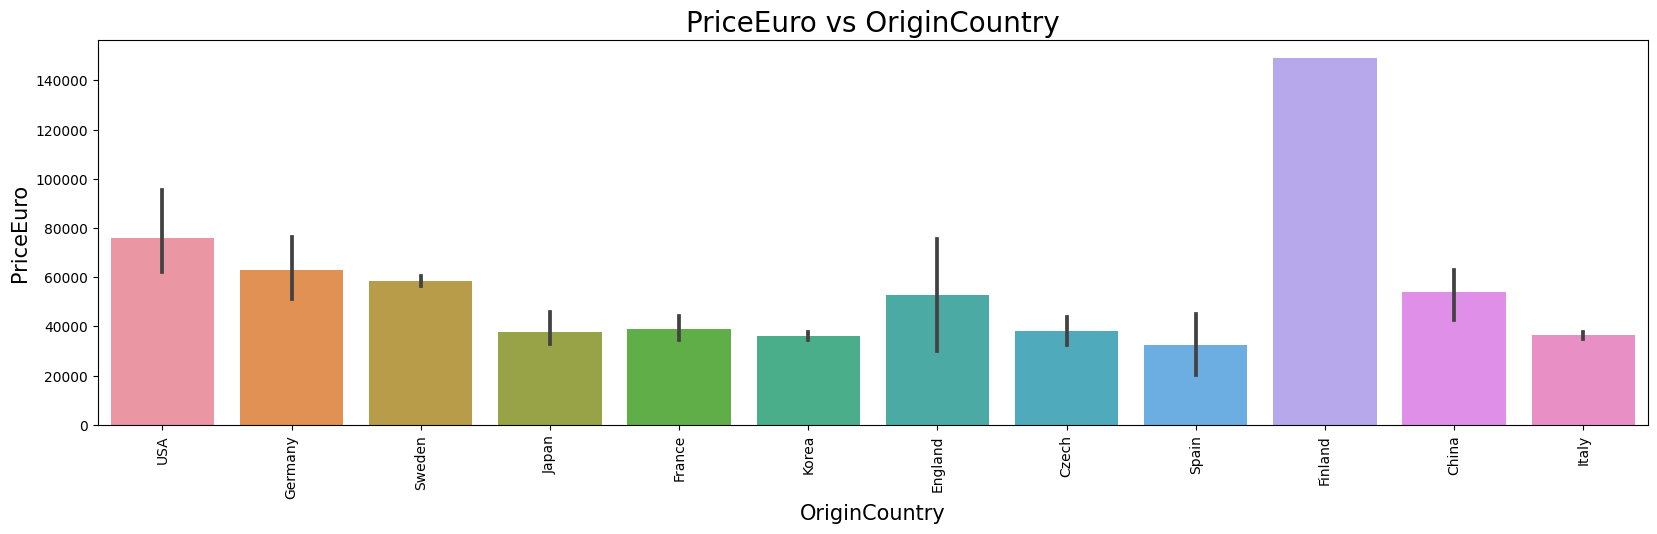

In [17]:
show_barplot("OriginCountry", "PriceEuro")

Несмотря на то, что Финляндия производит меньше всего электрических автомобилей, их машины имеют самую высокую цену. США и Германия, производящие наибольшое число электрических автомобилей, имеют цену выше средней.

Запомним признак **OriginCountry**.

### Количественный признак Accel

Выясним, какой тип имеет признак **Accel** в датасете:

In [18]:
df['Accel'].describe()

count         103
unique         55
top       9.0 sec
freq            7
Name: Accel, dtype: object

Видим, что признак **Ускорение** принимает 55 уникальных значений. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только значения числа с плавающей точкой плюс строка "sec.". Удалим строку ".sec" и уточним тип этого признака:

In [19]:
df['Accel'] = df['Accel'].apply(lambda x: x.replace( "sec", "")).astype('float64')
df['Accel'].describe()

count    103.000000
mean       7.396117
std        3.017430
min        2.100000
25%        5.100000
50%        7.300000
75%        9.000000
max       22.400000
Name: Accel, dtype: float64

Рассмотрим графики зависимости ускорения автомобиля от страны производителя и стоимости:

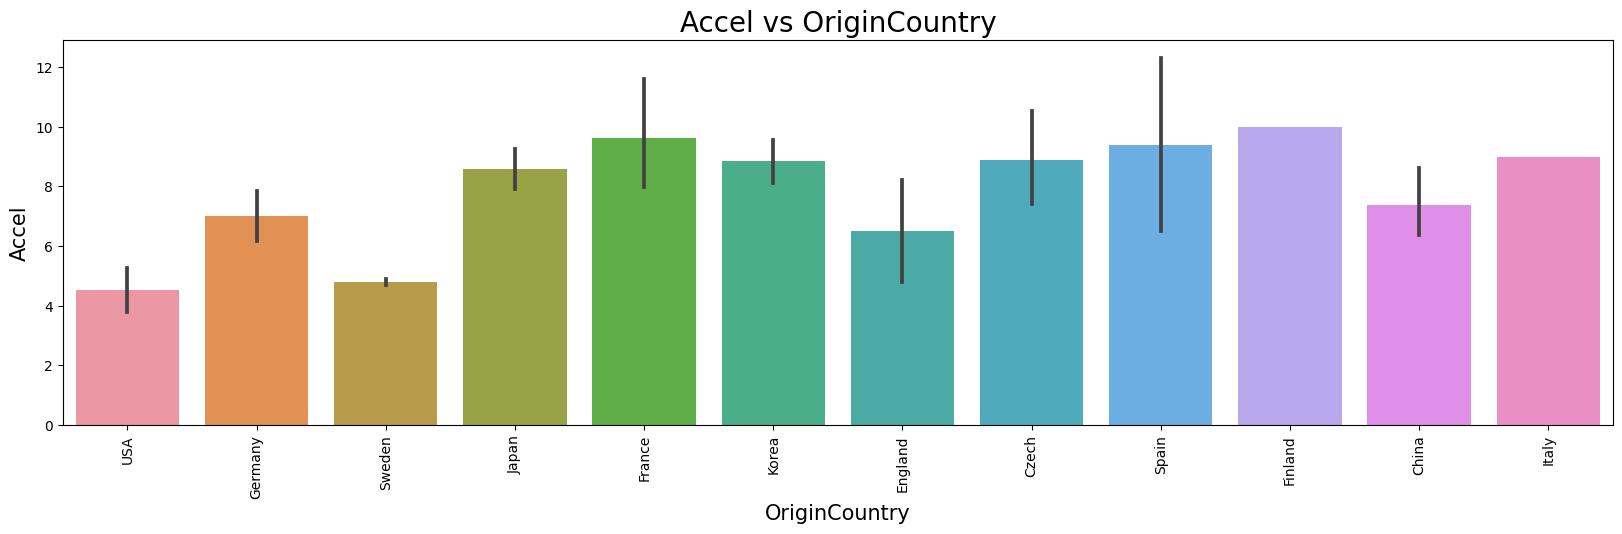

In [20]:
show_barplot("OriginCountry", "Accel")

Видим, что автомобили, быстрее всего выполяющие разгон 0--100, производятся в США. Самые медленный автомобили --- во Франции, Испании и Финляндии.

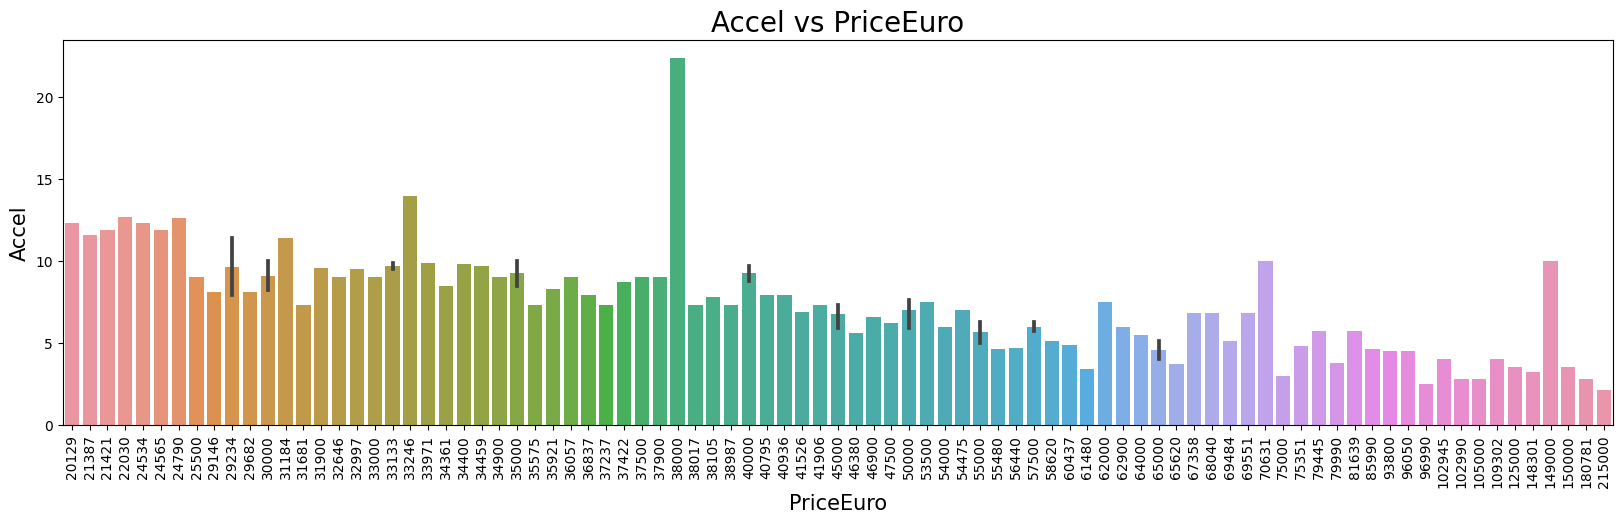

In [21]:
show_barplot("PriceEuro", "Accel")

Также видим тенденцию уменьшения разгоны 0--100 с увеличением цены автомобиля. Однако есть и исключения (например, автомобиль за 38000). Большинство автомобилей дороже 55000 евро разгоняются 0--100 меньше, чем за 5 секунд.

### Количественный признак TopSpeed

Выясним, какой тип имеет признак **TopSpeed** в датасете:

In [22]:
df['TopSpeed'].describe()

count          103
unique          25
top       160 km/h
freq            15
Name: TopSpeed, dtype: object

Видим, что признак **Максимальная скорость** принимает 25 уникальных значений. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только значения целого чиса плюс строка "km/h". Удалим строку "km/h" и уточним тип этого признака:

In [23]:
df['TopSpeed'] = df['TopSpeed'].apply(lambda x: x.replace( " km/h", "")).astype('int64')
df['TopSpeed'].describe()

count    103.000000
mean     179.194175
std       43.573030
min      123.000000
25%      150.000000
50%      160.000000
75%      200.000000
max      410.000000
Name: TopSpeed, dtype: float64

Рассмотрим графики зависимости максимальной скорости автомобиля от страны производителя и стоимости:

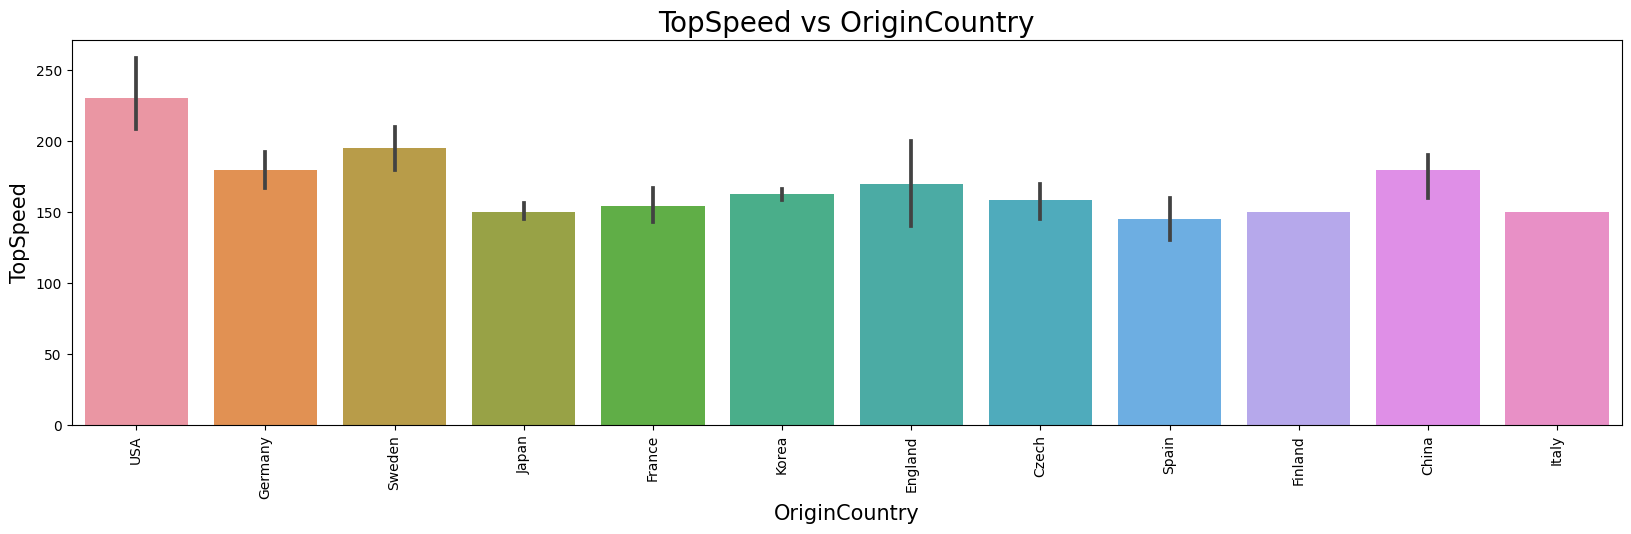

In [24]:
show_barplot("OriginCountry", "TopSpeed")

Видим, что автомобили, набирающие наибольшую максимальную скорость, производятся в США. Многие автомобили из других стран обладают примерно одинаковой максимальной скоростью, равной 150-170 км/ч.

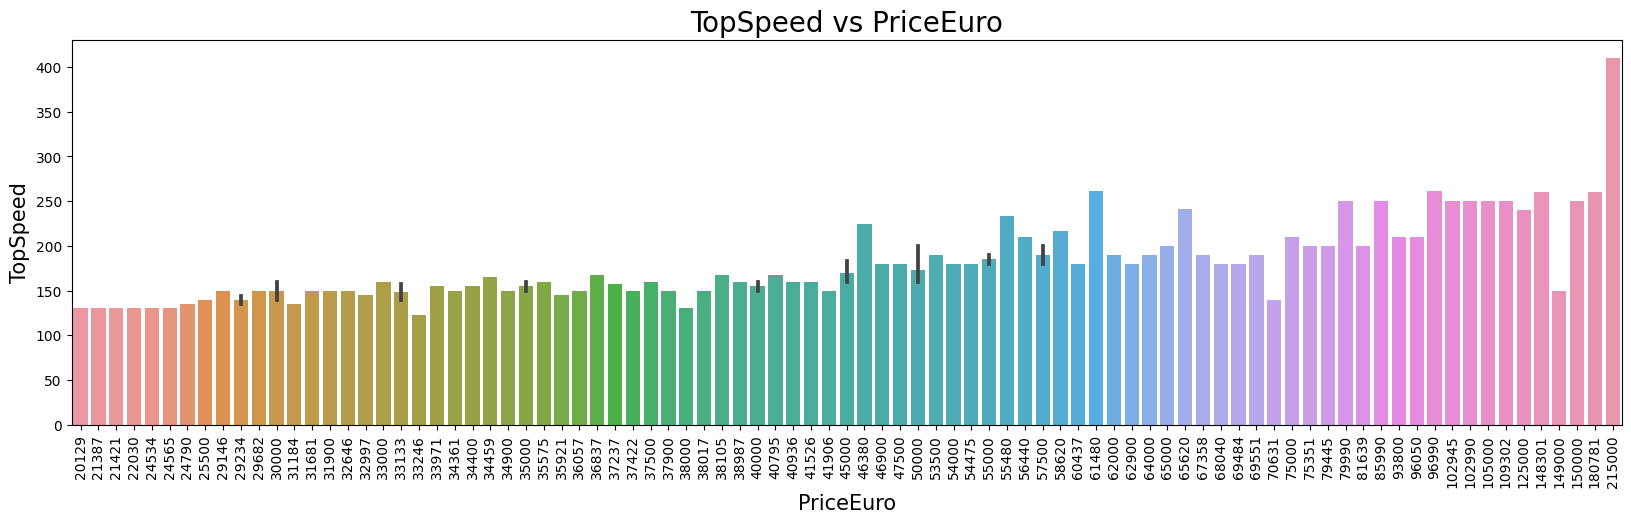

In [25]:
show_barplot("PriceEuro", "TopSpeed")

Также можно сделать вывод, что с увеличением стоимости автомобиля увеливается и его максимальная скорость. Многие автомобили дешевле 75000 евро не могут разогнаться до 200 км/ч.

### Количественный признак Range

Выясним, какой тип имеет признак **Range** в датасете:

In [26]:
df['Range'].describe()

count        103
unique        50
top       250 km
freq           6
Name: Range, dtype: object

Видим, что признак **Range** принимает 50 уникальных значений. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только значения целого чиса плюс строка "km". Удалим строку "km" и уточним тип этого признака:

In [27]:
df['Range'] = df['Range'].apply(lambda x: x.replace( " km", "")).astype('int64')
df['Range'].describe()

count    103.000000
mean     338.786408
std      126.014444
min       95.000000
25%      250.000000
50%      340.000000
75%      400.000000
max      970.000000
Name: Range, dtype: float64

Рассмотрим графики зависимости запаса хода автомобиля от страны производителя и стоимости:

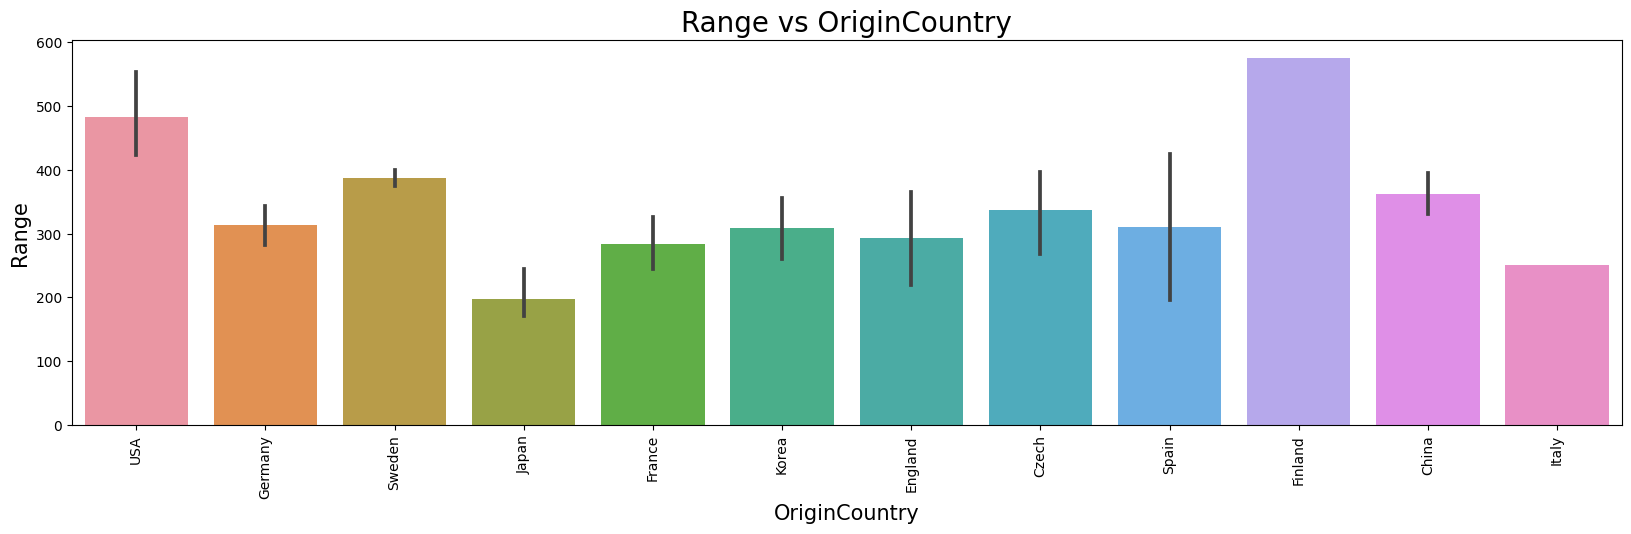

In [28]:
show_barplot("OriginCountry", "Range")

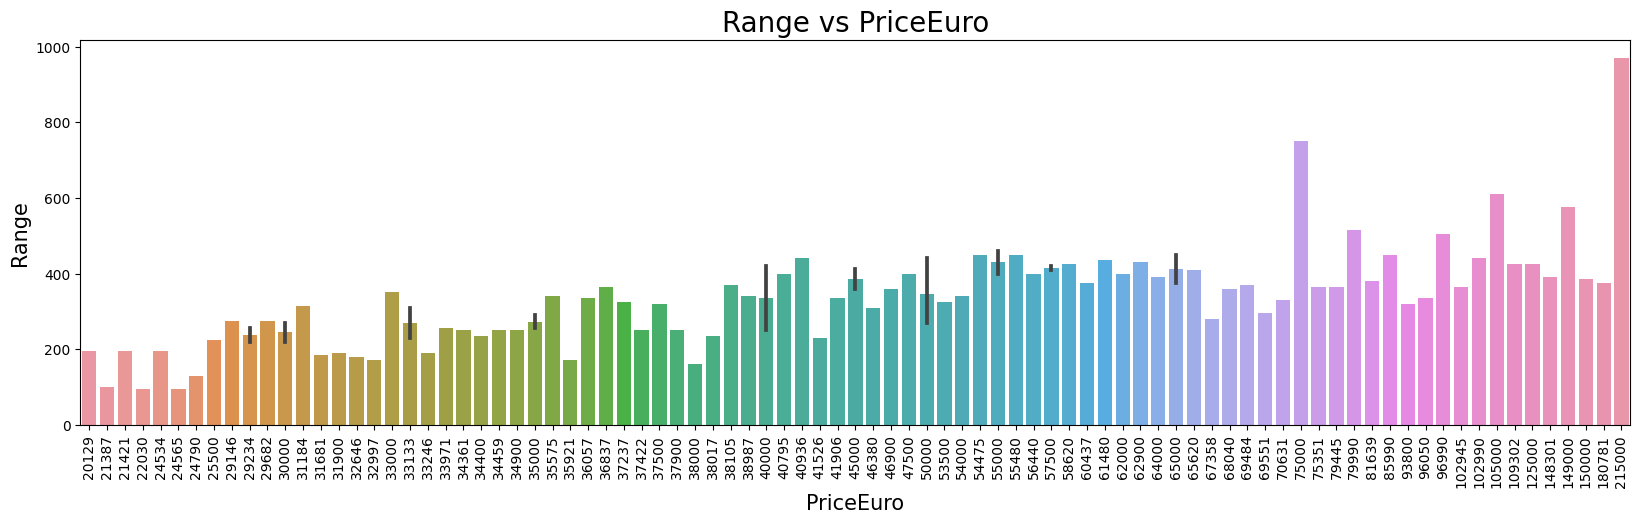

In [29]:
show_barplot("PriceEuro", "Range")

Видим, что автомобили, набирающие наибольшую максимальную скорость, производятся в США и Франции. Самый маленький запас хода имеют автомобили из Японии. Также можно сделать вывод, что с увеличением стоимости автомобиля увеливается и его максимальный запас хода. Однако многие автомобили дешевле 55000 евро обладают запасом хода меньше 400 км. Автомобили в бюджете выше 55000 евро имеют средний запас хода 400 км.

### Количественный признак Efficiency

Выясним, какой тип имеет признак **Efficiency** в датасете:

In [30]:
df['Efficiency'].describe()

count           103
unique           54
top       168 Wh/km
freq              6
Name: Efficiency, dtype: object

Видим, что признак **Efficiency** принимает 54 уникальных значения. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только значения целого чиса плюс строка "WH/km". Удалим строку "WH/km" и уточним тип этого признака:

In [31]:
df['Efficiency'] = df['Efficiency'].apply(lambda x: x.replace( " Wh/km", "")).astype('int64')
df['Efficiency'].describe()

count    103.000000
mean     189.165049
std       29.566839
min      104.000000
25%      168.000000
50%      180.000000
75%      203.000000
max      273.000000
Name: Efficiency, dtype: float64

Рассмотрим графики зависимости эффективности автомобиля от страны производителя и стоимости:

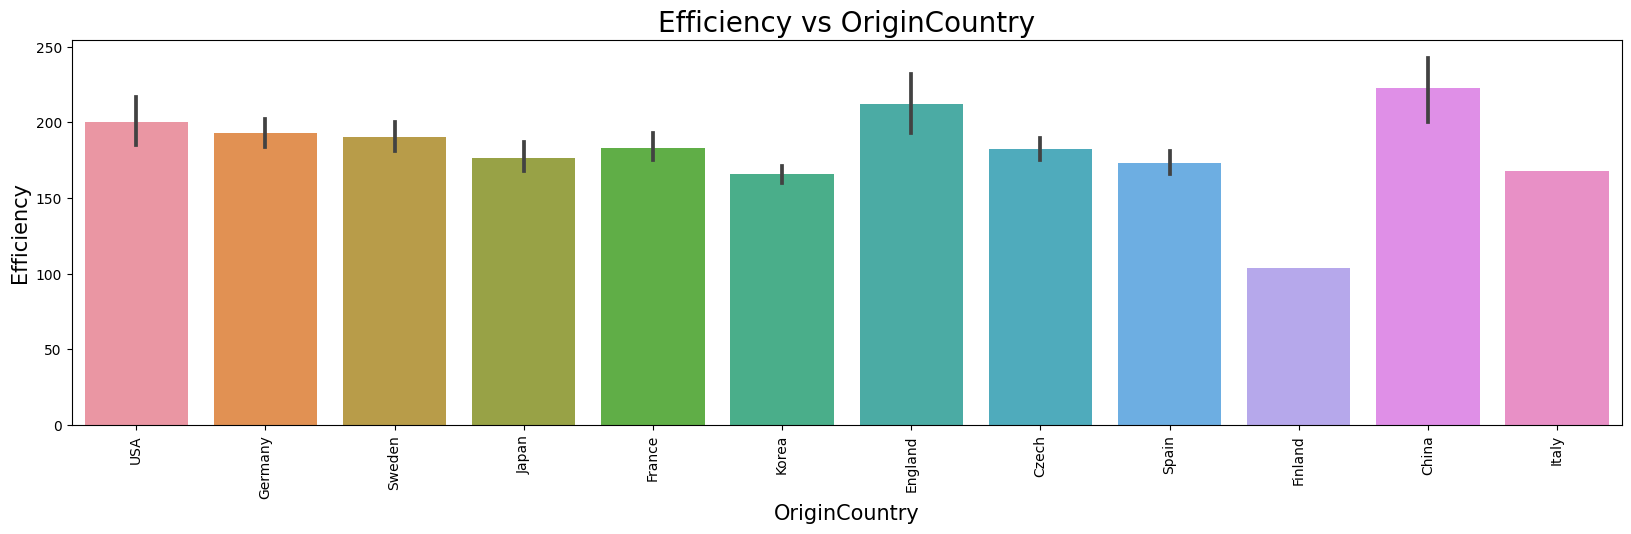

In [32]:
show_barplot("OriginCountry", "Efficiency")

Видим, что наибольшей эффективностью обладают электрические автомобили из Англии и Китая --- их эффективность выше 200 Wh/km. Наименьшей эффективностью обладают автомобили из Финляндии. Остальные электромобили обладают примерно одинаковой эффективностью.

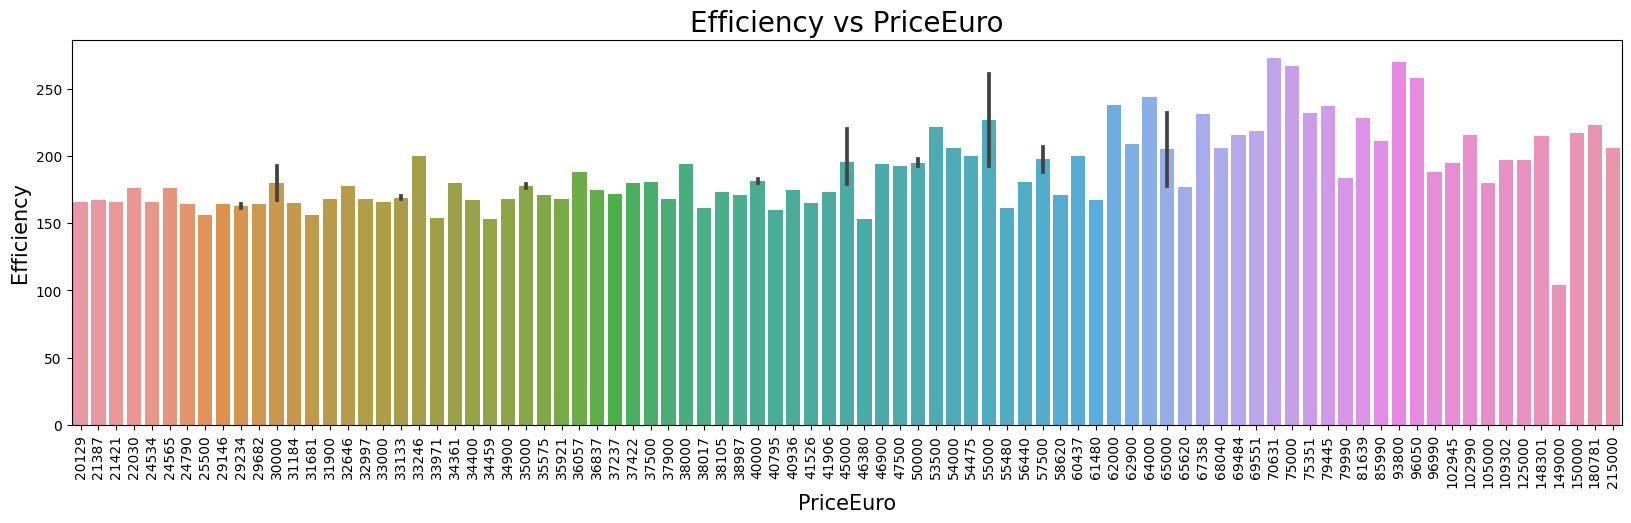

In [33]:
show_barplot("PriceEuro", "Efficiency")

Видим, что большинство автомобилей дешевле 55000 евро обладают примерно одной эффективностью: от 150 до 200 Wh/km. Часть автомобилей дороже 55000 евро имеют эффективность выше 200, однако есть автомобили, чья эффективность примерно равна или даже меньше эффективности бюджетных машин.

### Количественный признак FastCharge

Выясним, какой тип имеет признак **FastCharge** в датасете:

In [34]:
df['FastCharge'].describe()

count          103
unique          51
top       230 km/h
freq             6
Name: FastCharge, dtype: object

Видим, что признак **FastCharge** принимает 51 уникальное значение. В датасете этот признак по умолчанию имеет тип *object*, хотя принимает только значения целого чиса плюс строка "km/h" и "-". Сначала заменим "-" на "0 km/h", а потом удалим строку "km/h" и уточним тип этого признака:

In [35]:
df['FastCharge'] = df['FastCharge'].apply(lambda x: x if x != "-" else "0 km/h")
df['FastCharge'] = df['FastCharge'].apply(lambda x: x.replace("km/h", "")).astype('int64')
df['FastCharge'].describe()

count    103.000000
mean     434.563107
std      219.660061
min        0.000000
25%      260.000000
50%      440.000000
75%      555.000000
max      940.000000
Name: FastCharge, dtype: float64

Рассмотрим автомобили с нулевой скоростью зарядки:

In [36]:
df[df['FastCharge'] == 0]

,Brand,Model,Accel,TopSpeed,Range,Efficiency,FastCharge,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,OriginCountry
57,Renault,Twingo ZE,12.6,135,130,164,0,Rapid charging not possible,Rear Wheel Drive,Type 2,Hatchback,A,4,24790,France
68,Renault,Kangoo Maxi ZE 33,22.4,130,160,194,0,Rapid charging not possible,Front Wheel Drive,Type 2,SPV,N,5,38000,France
77,Smart,EQ forfour,12.7,130,95,176,0,Rapid charging not possible,Rear Wheel Drive,Type 2,Hatchback,A,4,22030,Germany
82,Smart,EQ fortwo coupe,11.6,130,100,167,0,Rapid charging not possible,Rear Wheel Drive,Type 2,Hatchback,A,2,21387,Germany
91,Smart,EQ fortwo cabrio,11.9,130,95,176,0,Rapid charging not possible,Rear Wheel Drive,Type 2,Cabrio,A,2,24565,Germany


Видим, что это автомобили из Франции и Германии, для которых недоступна быстрая зарядка. В наше выборке было достаточно автомобилей из этих стран, поэтому заменим нулевые значения минимальные значения скорости зарядки по странам, делённые на два.

In [37]:
df.loc[(df['FastCharge'] == 0) & (df['OriginCountry'] == 'France'), 'FastCharge'] = df.loc[(df['FastCharge'] != 0) & (df['OriginCountry'] == 'France'), 'FastCharge'].min() // 2
df.loc[(df['FastCharge'] == 0) & (df['OriginCountry'] == 'Germany'), 'FastCharge'] = df.loc[(df['FastCharge'] != 0) & (df['OriginCountry'] == 'Germany'), 'FastCharge'].min() // 2
df[df['FastCharge'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          0 non-null      object 
 1   Model          0 non-null      object 
 2   Accel          0 non-null      float64
 3   TopSpeed       0 non-null      int64  
 4   Range          0 non-null      int64  
 5   Efficiency     0 non-null      int64  
 6   FastCharge     0 non-null      int64  
 7   RapidCharge    0 non-null      object 
 8   PowerTrain     0 non-null      object 
 9   PlugType       0 non-null      object 
 10  BodyStyle      0 non-null      object 
 11  Segment        0 non-null      object 
 12  Seats          0 non-null      int64  
 13  PriceEuro      0 non-null      int64  
 14  OriginCountry  0 non-null      object 
dtypes: float64(1), int64(6), object(8)
memory usage: 0.0+ bytes


Рассмотрим графики зависимости эффективности автомобиля от страны производителя и стоимости:

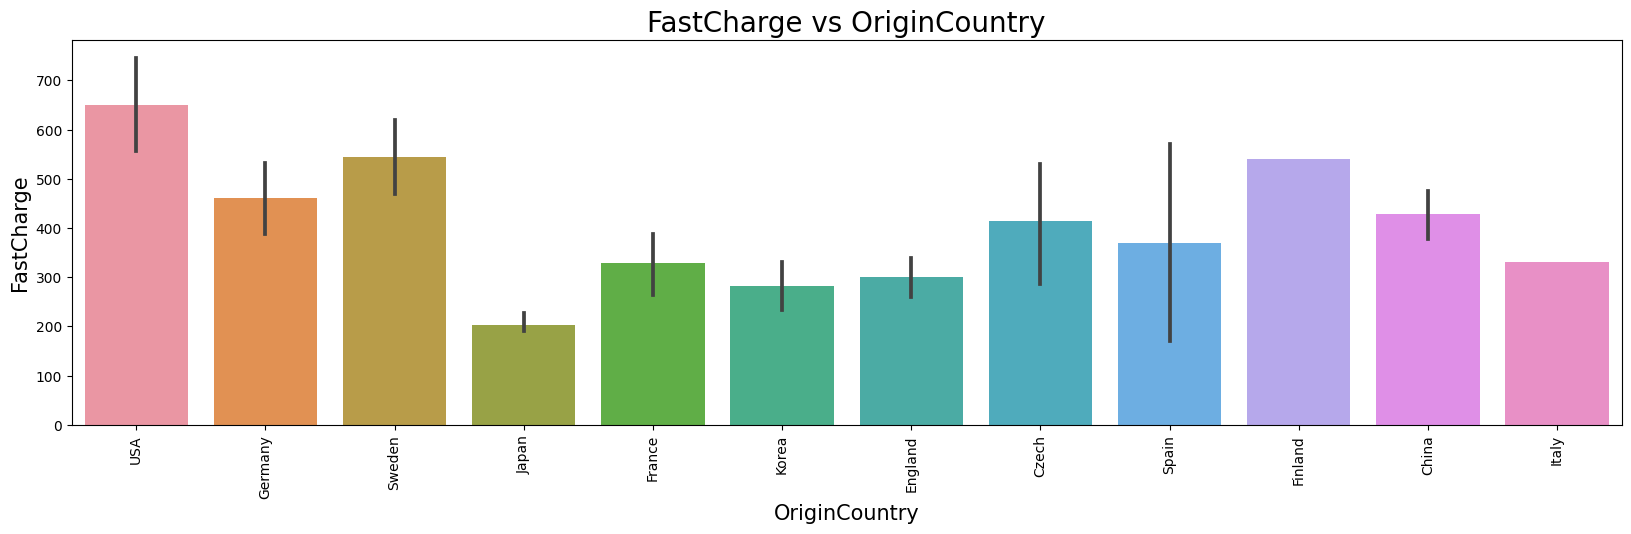

In [38]:
show_barplot("OriginCountry", "FastCharge")

Видим, что самые эффективные электромобили производятся в США. Самые малоэффективные --- в Японии.

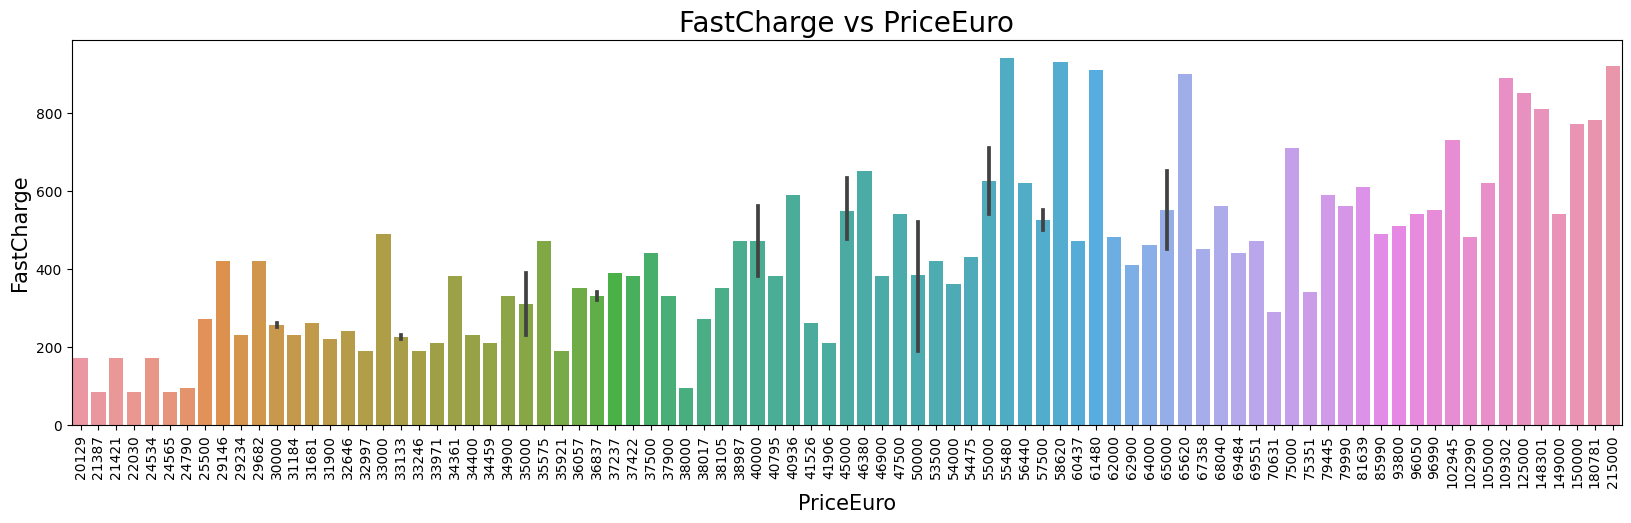

In [39]:
show_barplot("PriceEuro", "FastCharge")

Также можно сделать вывод, что с увеличением цены растёт и эффективность электромобилей. Однако эта зависимость не совсем прямолинейная: видим достаточно много исключений.

### Категориальный признак RapidCharge

Выясним, какой тип имеет признак **RapidCharge** в датасете:

In [40]:
df['RapidCharge'].describe()

count                         103
unique                          2
top       Rapid charging possible
freq                           98
Name: RapidCharge, dtype: object

Видим, что признак **RapidCharge** принимает всего два уникальных значения. Запомним это. Также можно заметить, что этот признак принимает только строковые значения, хотя в датасете указан как *object*. Уточним значение признака **RapidCharge**:

In [41]:
df['RapidCharge'] = df['RapidCharge'].astype('|S').apply(lambda s: s.strip()).str.decode('utf-8')
df['RapidCharge'].describe()

count                         103
unique                          2
top       Rapid charging possible
freq                           98
Name: RapidCharge, dtype: object

Из предыдущего признака помним, что только два автомобиля из Франции и три из Германии не обладают быстрой зарядкой.

In [42]:
df.loc[df['RapidCharge'] == 'Rapid charging not possible', 'PriceEuro'].mean()

26154.4000

Видим, что средняя цена автомобилей, не обладающих быстрой зарядкой, более чем в два раза ниже средней цены (55811 евро) автомобиля из выборки.

### Категориальный признак PowerTrain

Выясним, какой тип имеет признак **PowerTrain** в датасете:

In [43]:
df['PowerTrain'].describe()

count                 103
unique                  3
top       All Wheel Drive
freq                   41
Name: PowerTrain, dtype: object

Видим, что признак **PowerTrain** принимает всего три уникальных значения. Запомним это. Также можно заметить, что этот признак принимает только строковые значения, хотя в датасете указан как *object*. Уточним значение признака **PowerTrain**:

In [44]:
df['PowerTrain'] = df['PowerTrain'].astype('|S').apply(lambda s: s.strip()).str.decode('utf-8')
df['PowerTrain'].describe()

count                 103
unique                  3
top       All Wheel Drive
freq                   41
Name: PowerTrain, dtype: object

Видим, что большинство электромобилей имеют полный привод.

Введём дополнительную функцию отрисовки графиков по **OriginCountry** и переданному признаку:

In [45]:
def show_coutries_barplot(column):
    figure, axis = plt.subplots(3, 4, figsize = (25, 20))
    
    df[df['OriginCountry'] == 'USA'][column].value_counts().plot.bar(ax = axis[0, 0])
    axis[0, 0].set_title("USA")
    
    df[df['OriginCountry'] == 'Germany'][column].value_counts().plot.bar(ax = axis[0, 1])
    axis[0, 1].set_title("Germany")
    
    df[df['OriginCountry'] == 'Sweden'][column].value_counts().plot.bar(ax = axis[0, 2])
    axis[0, 2].set_title("Sweden")

    df[df['OriginCountry'] == 'Japan'][column].value_counts().plot.bar(ax = axis[0, 3])
    axis[0, 3].set_title("Japan")
    
    df[df['OriginCountry'] == 'France'][column].value_counts().plot.bar(ax = axis[1, 0])
    axis[1, 0].set_title("France")
    
    df[df['OriginCountry'] == 'Korea'][column].value_counts().plot.bar(ax = axis[1, 1])
    axis[1, 1].set_title("Korea")
    
    df[df['OriginCountry'] == 'England'][column].value_counts().plot.bar(ax = axis[1, 2])
    axis[1, 2].set_title("England")
    
    df[df['OriginCountry'] == 'Czech'][column].value_counts().plot.bar(ax = axis[1, 3])
    axis[1, 3].set_title("Czech")
    
    df[df['OriginCountry'] == 'Spain'][column].value_counts().plot.bar(ax = axis[2, 0])
    axis[2, 0].set_title("Spain")
    
    df[df['OriginCountry'] == 'Finland'][column].value_counts().plot.bar(ax = axis[2, 1])
    axis[2, 1].set_title("Finland")
    
    df[df['OriginCountry'] == 'China'][column].value_counts().plot.bar(ax = axis[2, 2])
    axis[2, 2].set_title("China")
    
    df[df['OriginCountry'] == 'Italy'][column].value_counts().plot.bar(ax = axis[2, 3])
    axis[2, 3].set_title("Italy")
    
    plt.show()

Рассмотрим графики зависимости привода автомобиля от страны производителя и стоимости.

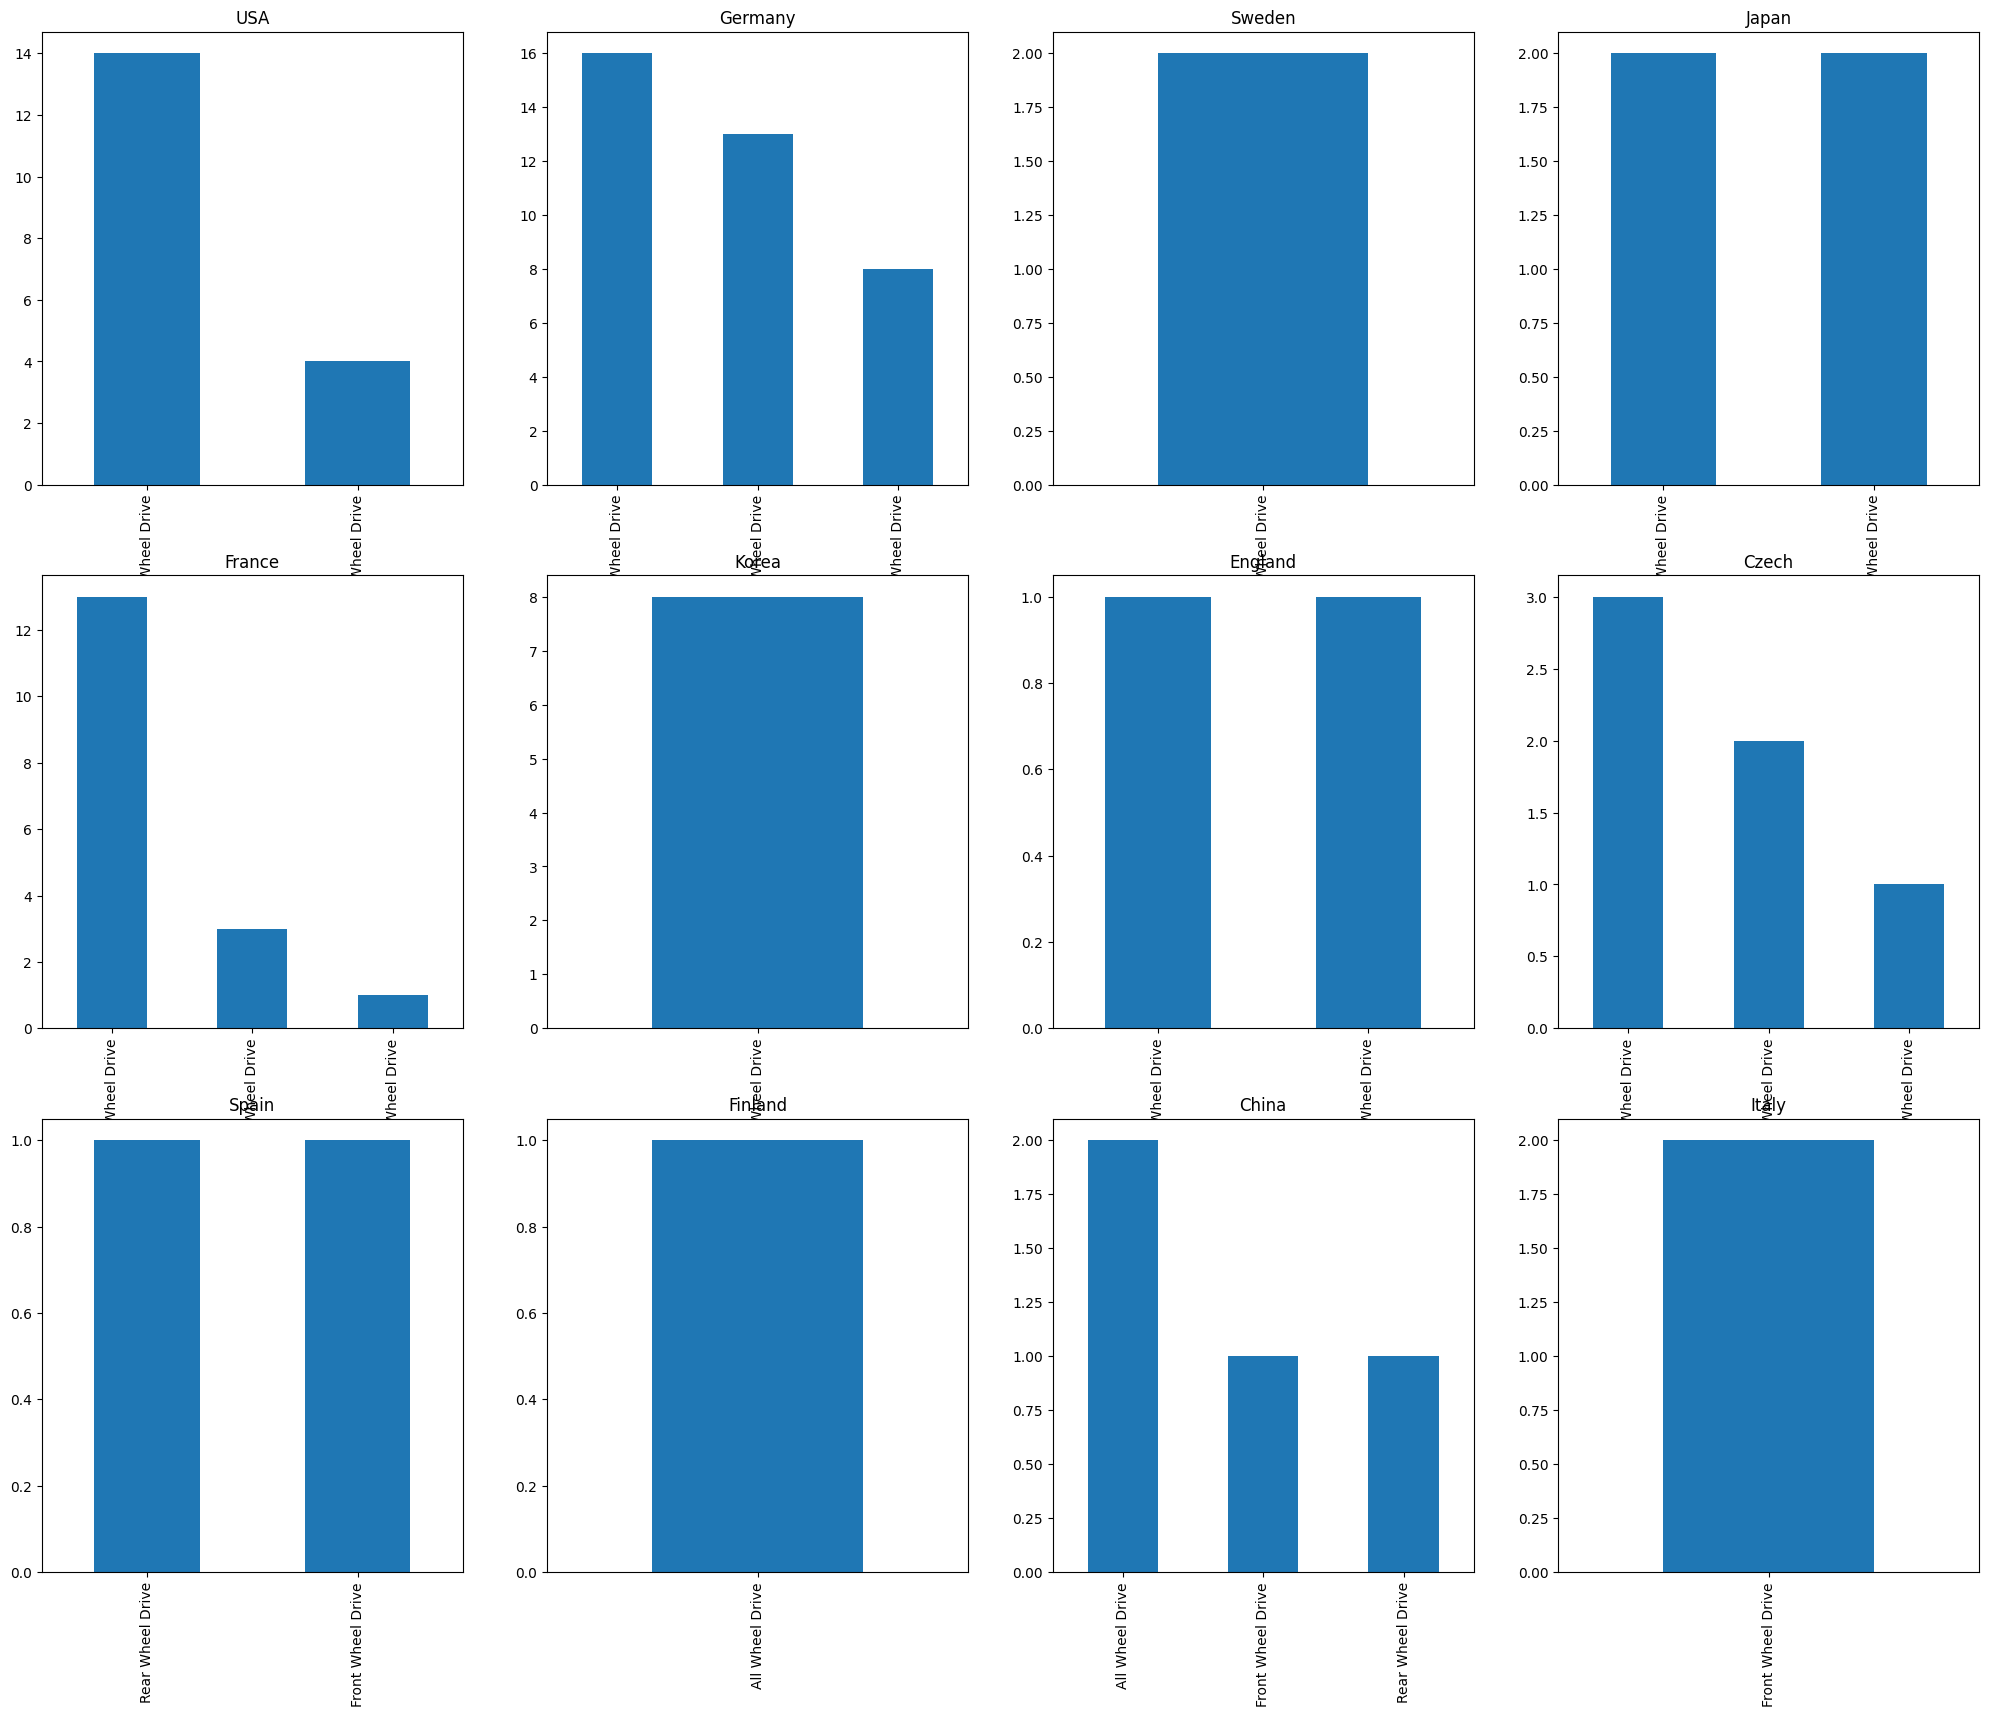

In [46]:
show_coutries_barplot('PowerTrain')

Видим по графику, что во Франции, Корее и Италии предпочитают переднеприводные электромобили, в Японии, Англии, Испании одинаковое число автомобилей всех приводов (заднего, переднего и полного). Во всех остальных странах предпочитают полноприводные электрические автомобили.

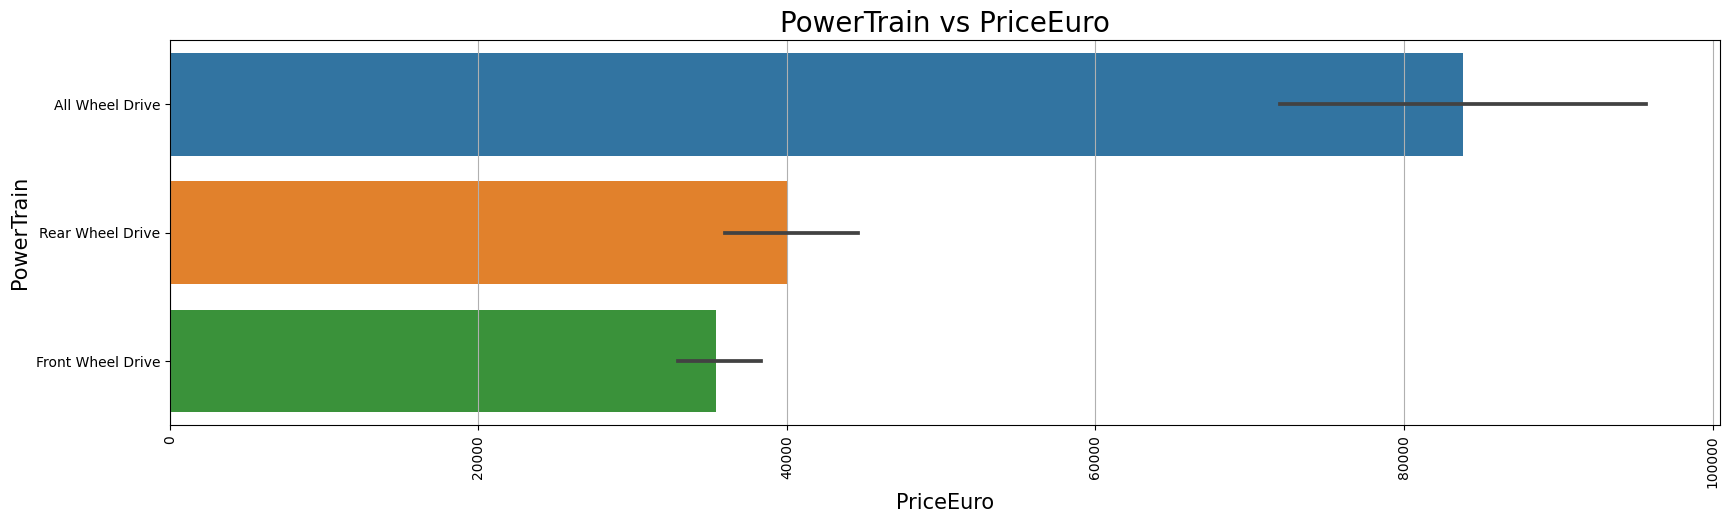

In [47]:
show_barplot("PriceEuro", "PowerTrain")

Также можно сделать вывод, что полноприводные электромобили стоят более чем в два раза дороже своих моноприводных конкурентов. Бюджетнее всего переднеприводные электромобили.

### Категориальный признак PlugType

Выясним, какой тип имеет признак **PlugType** в датасете:

In [48]:
df['PlugType'].describe()

count            103
unique             4
top       Type 2 CCS
freq              90
Name: PlugType, dtype: object

Видим, что признак **PlugType** принимает всего четыре уникальных значения. Запомним это. Также можно заметить, что этот признак принимает только строковые значения, хотя в датасете указан как *object*. Уточним значение признака **PlugType**:

In [49]:
df['PlugType'] = df['PlugType'].astype('|S').apply(lambda s: s.strip()).str.decode('utf-8')
df['PlugType'].describe()

count            103
unique             4
top       Type 2 CCS
freq              90
Name: PlugType, dtype: object

Видим, что большинство электромобилей имеют тип зарядки *Type 2 CCS*.

Рассмотрим графики зависимости типа зарядки автомобиля от страны производителя и стоимости:

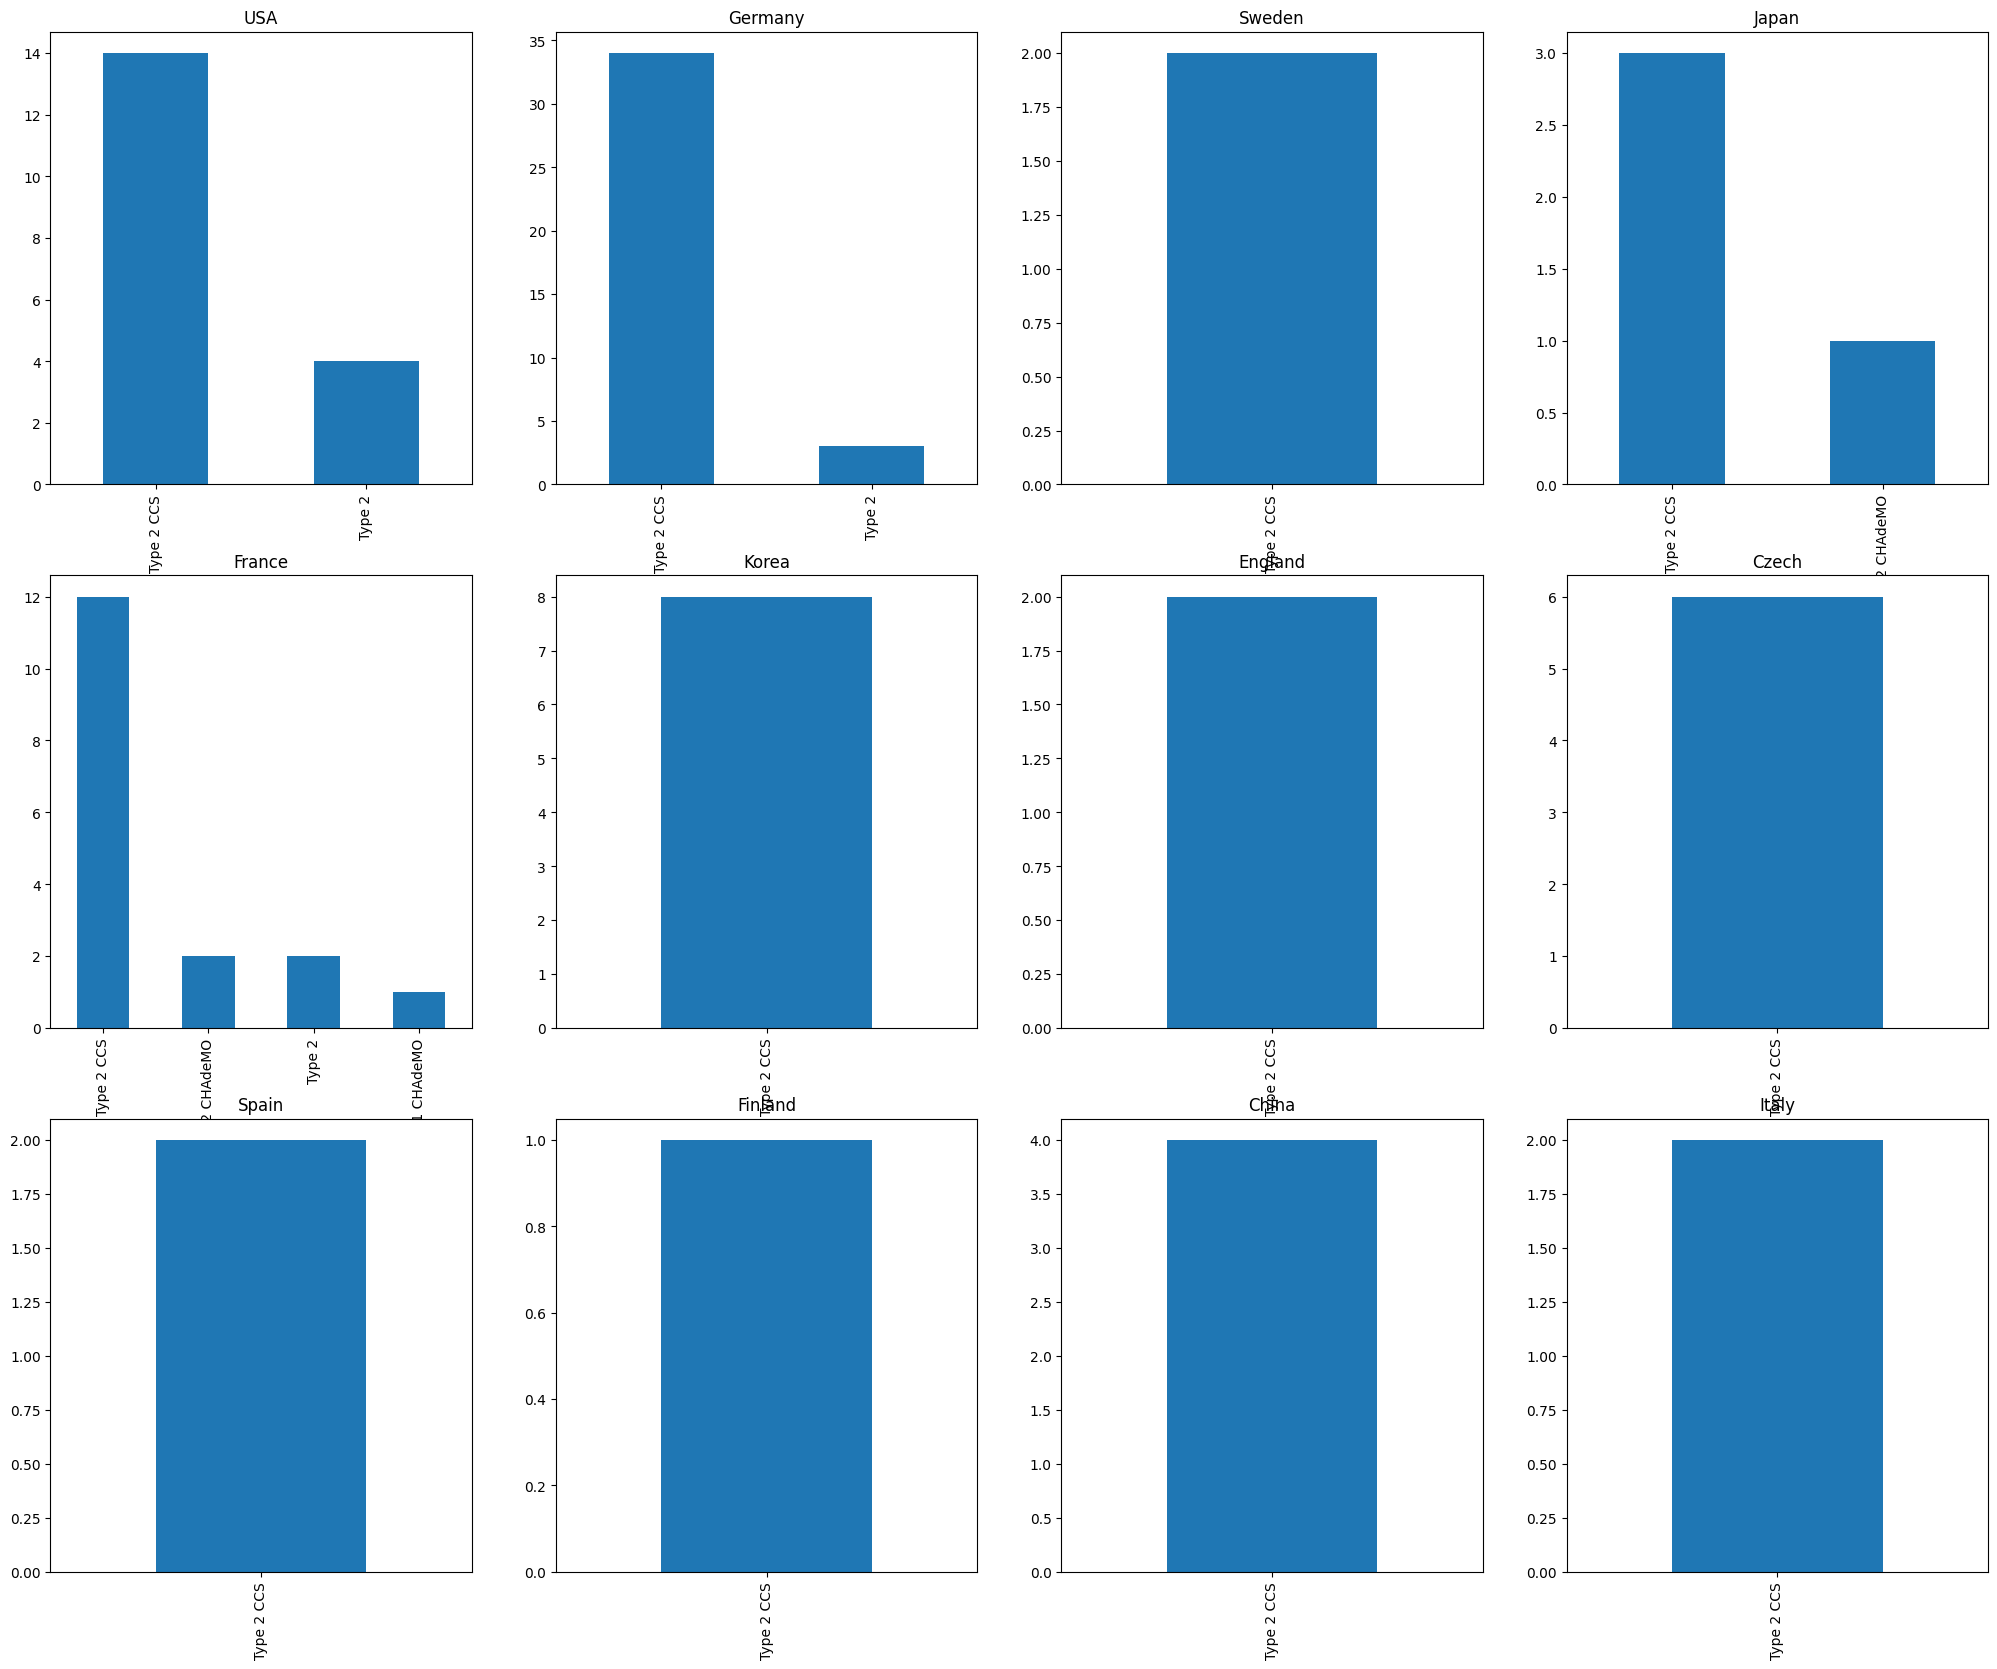

In [50]:
show_coutries_barplot('PlugType')

Видим, что во всех странах преобладает тип зарядки *Type 2 CCS*.

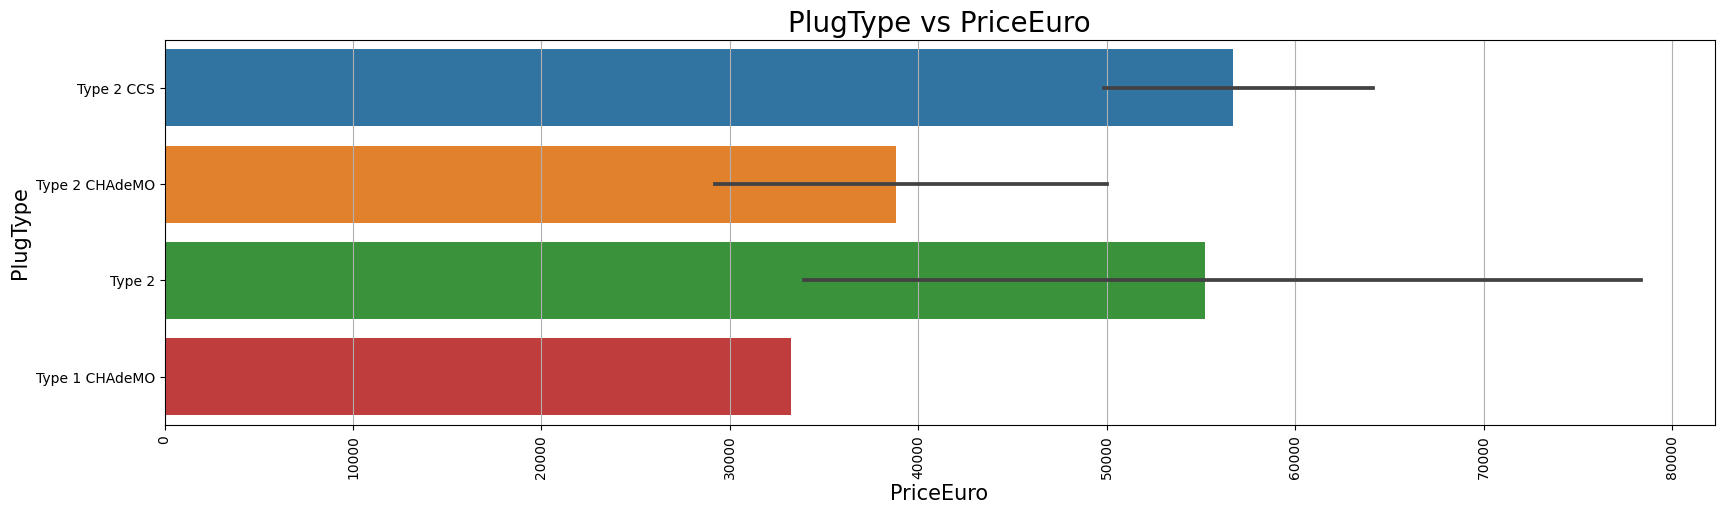

In [51]:
show_barplot("PriceEuro", "PlugType")

Также можно сделать вывод, что автомобили с типом зарядки *Type 2 CCS* стоят дороже своих конкурентов. Однако стоит заметить, что автомобили с типом зарядки *Type 2* стоят на уровне, а иногда и дороже всех остальных автомобилей с другим типом зарядки.

### Категориальный признак BodyStyle

Выясним, какой тип имеет признак **BodyStyle** в датасете:

In [52]:
df['BodyStyle'].describe()

count     103
unique      9
top       SUV
freq       45
Name: BodyStyle, dtype: object

Видим, что признак **BodyStyle** принимает всего девять уникальных значений. Запомним это. Также можно заметить, что этот признак принимает только строковые значения, хотя в датасете указан как *object*. Уточним значение признака **BodyStyle**:

In [53]:
df['BodyStyle'] = df['BodyStyle'].astype('|S').apply(lambda s: s.strip()).str.decode('utf-8')
df['BodyStyle'].describe()

count     103
unique      9
top       SUV
freq       45
Name: BodyStyle, dtype: object

Видим, что большинство электромобилей имеют тип кузова *SUV*.

Рассмотрим графики зависимости типа кузова автомобиля от страны производителя и стоимости:

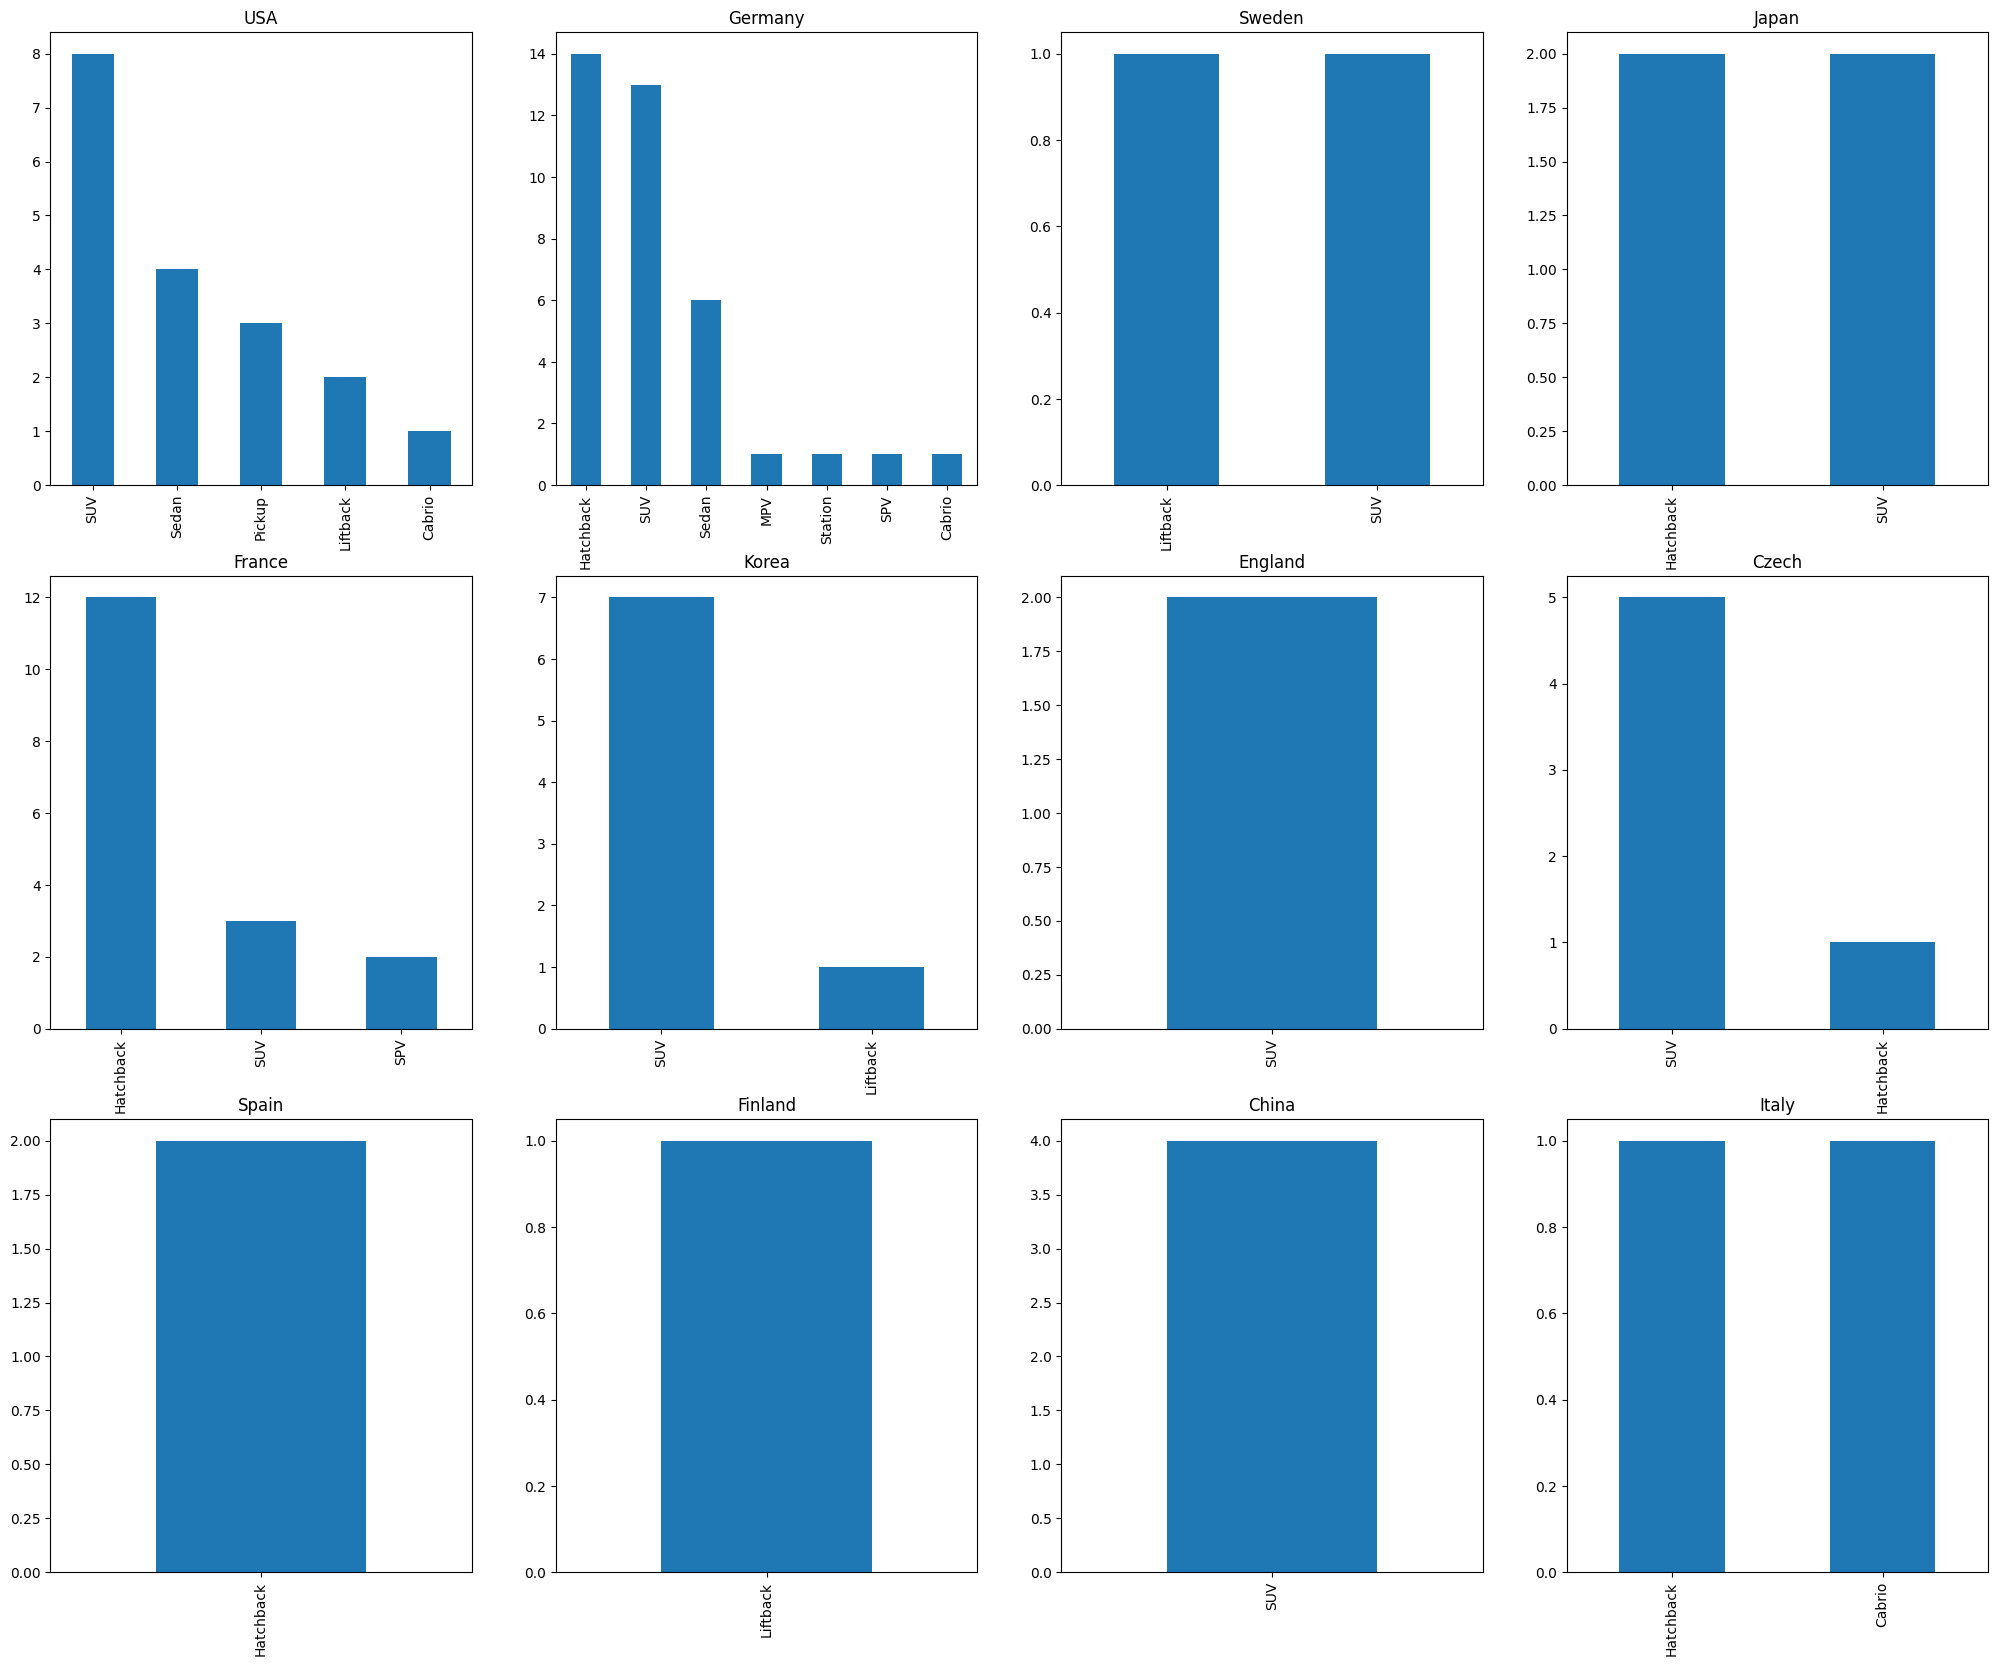

In [54]:
show_coutries_barplot('BodyStyle')

Из графиков видно, что в США, Корее, Англии, Чехии и Китае предпочитают электромобили с типом кузова *SUV*. В Германии, Японии, Франции, Испании и Италии предпочитают электромобили с типом кузова *Hatchback*. В Швеции и Финляндии предпочитают электромобили с типом кузова *Liftback*.

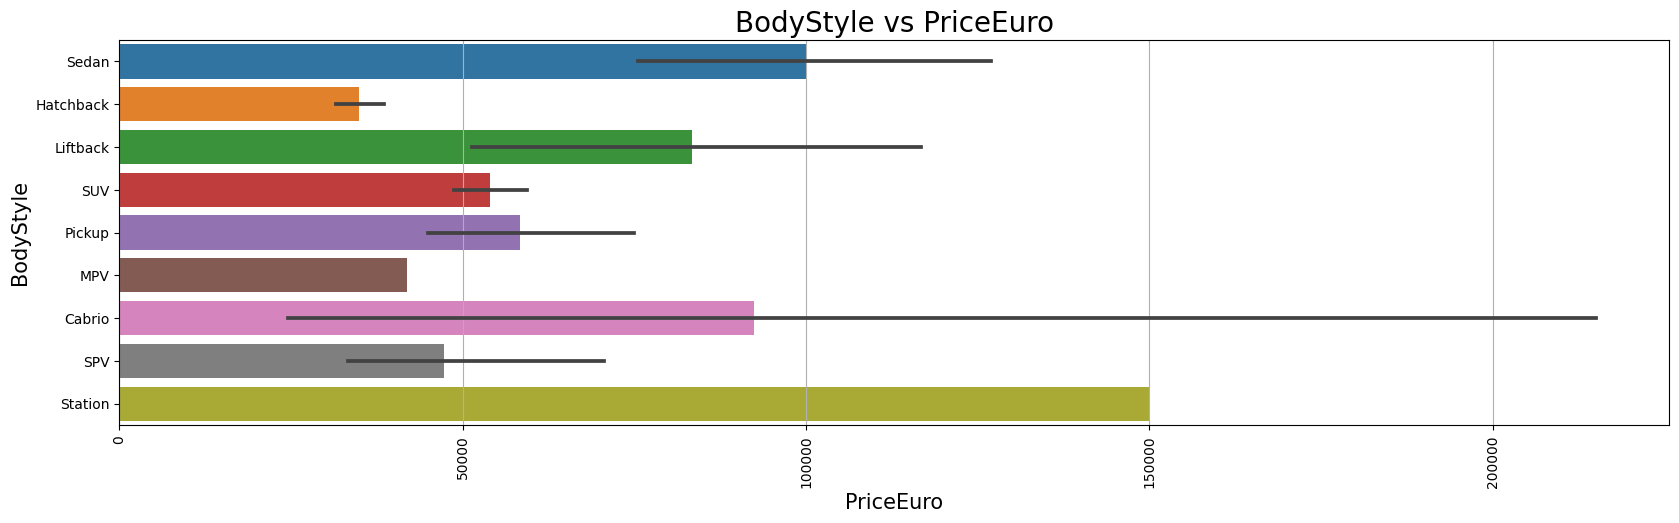

In [55]:
show_barplot("PriceEuro", "BodyStyle")

Также можем сделать, что самые дорогие автомобили имеют тип *Station* и *Cabrio*. Самые бюджетные электрические автомобили --- *Hatchback*.

### Категориальный признак Segment

Выясним, какой тип имеет признак **Segment** в датасете:

In [56]:
df['Segment'].describe()

count     103
unique      8
top         C
freq       30
Name: Segment, dtype: object

Видим, что признак **Segment** принимает всего восемь уникальных значений. Запомним это. Также можно заметить, что этот признак принимает только строковые значения, хотя в датасете указан как *object*. Уточним значение признака **Segment**:

In [57]:
df['Segment'] = df['Segment'].astype('|S').apply(lambda s: s.strip()).str.decode('utf-8')
df['Segment'].describe()

count     103
unique      8
top         C
freq       30
Name: Segment, dtype: object

Видим, что большинство электромобилей имеют тип *C*.

Рассмотрим графики зависимости тип класса автомобиля от страны производителя и стоимости:

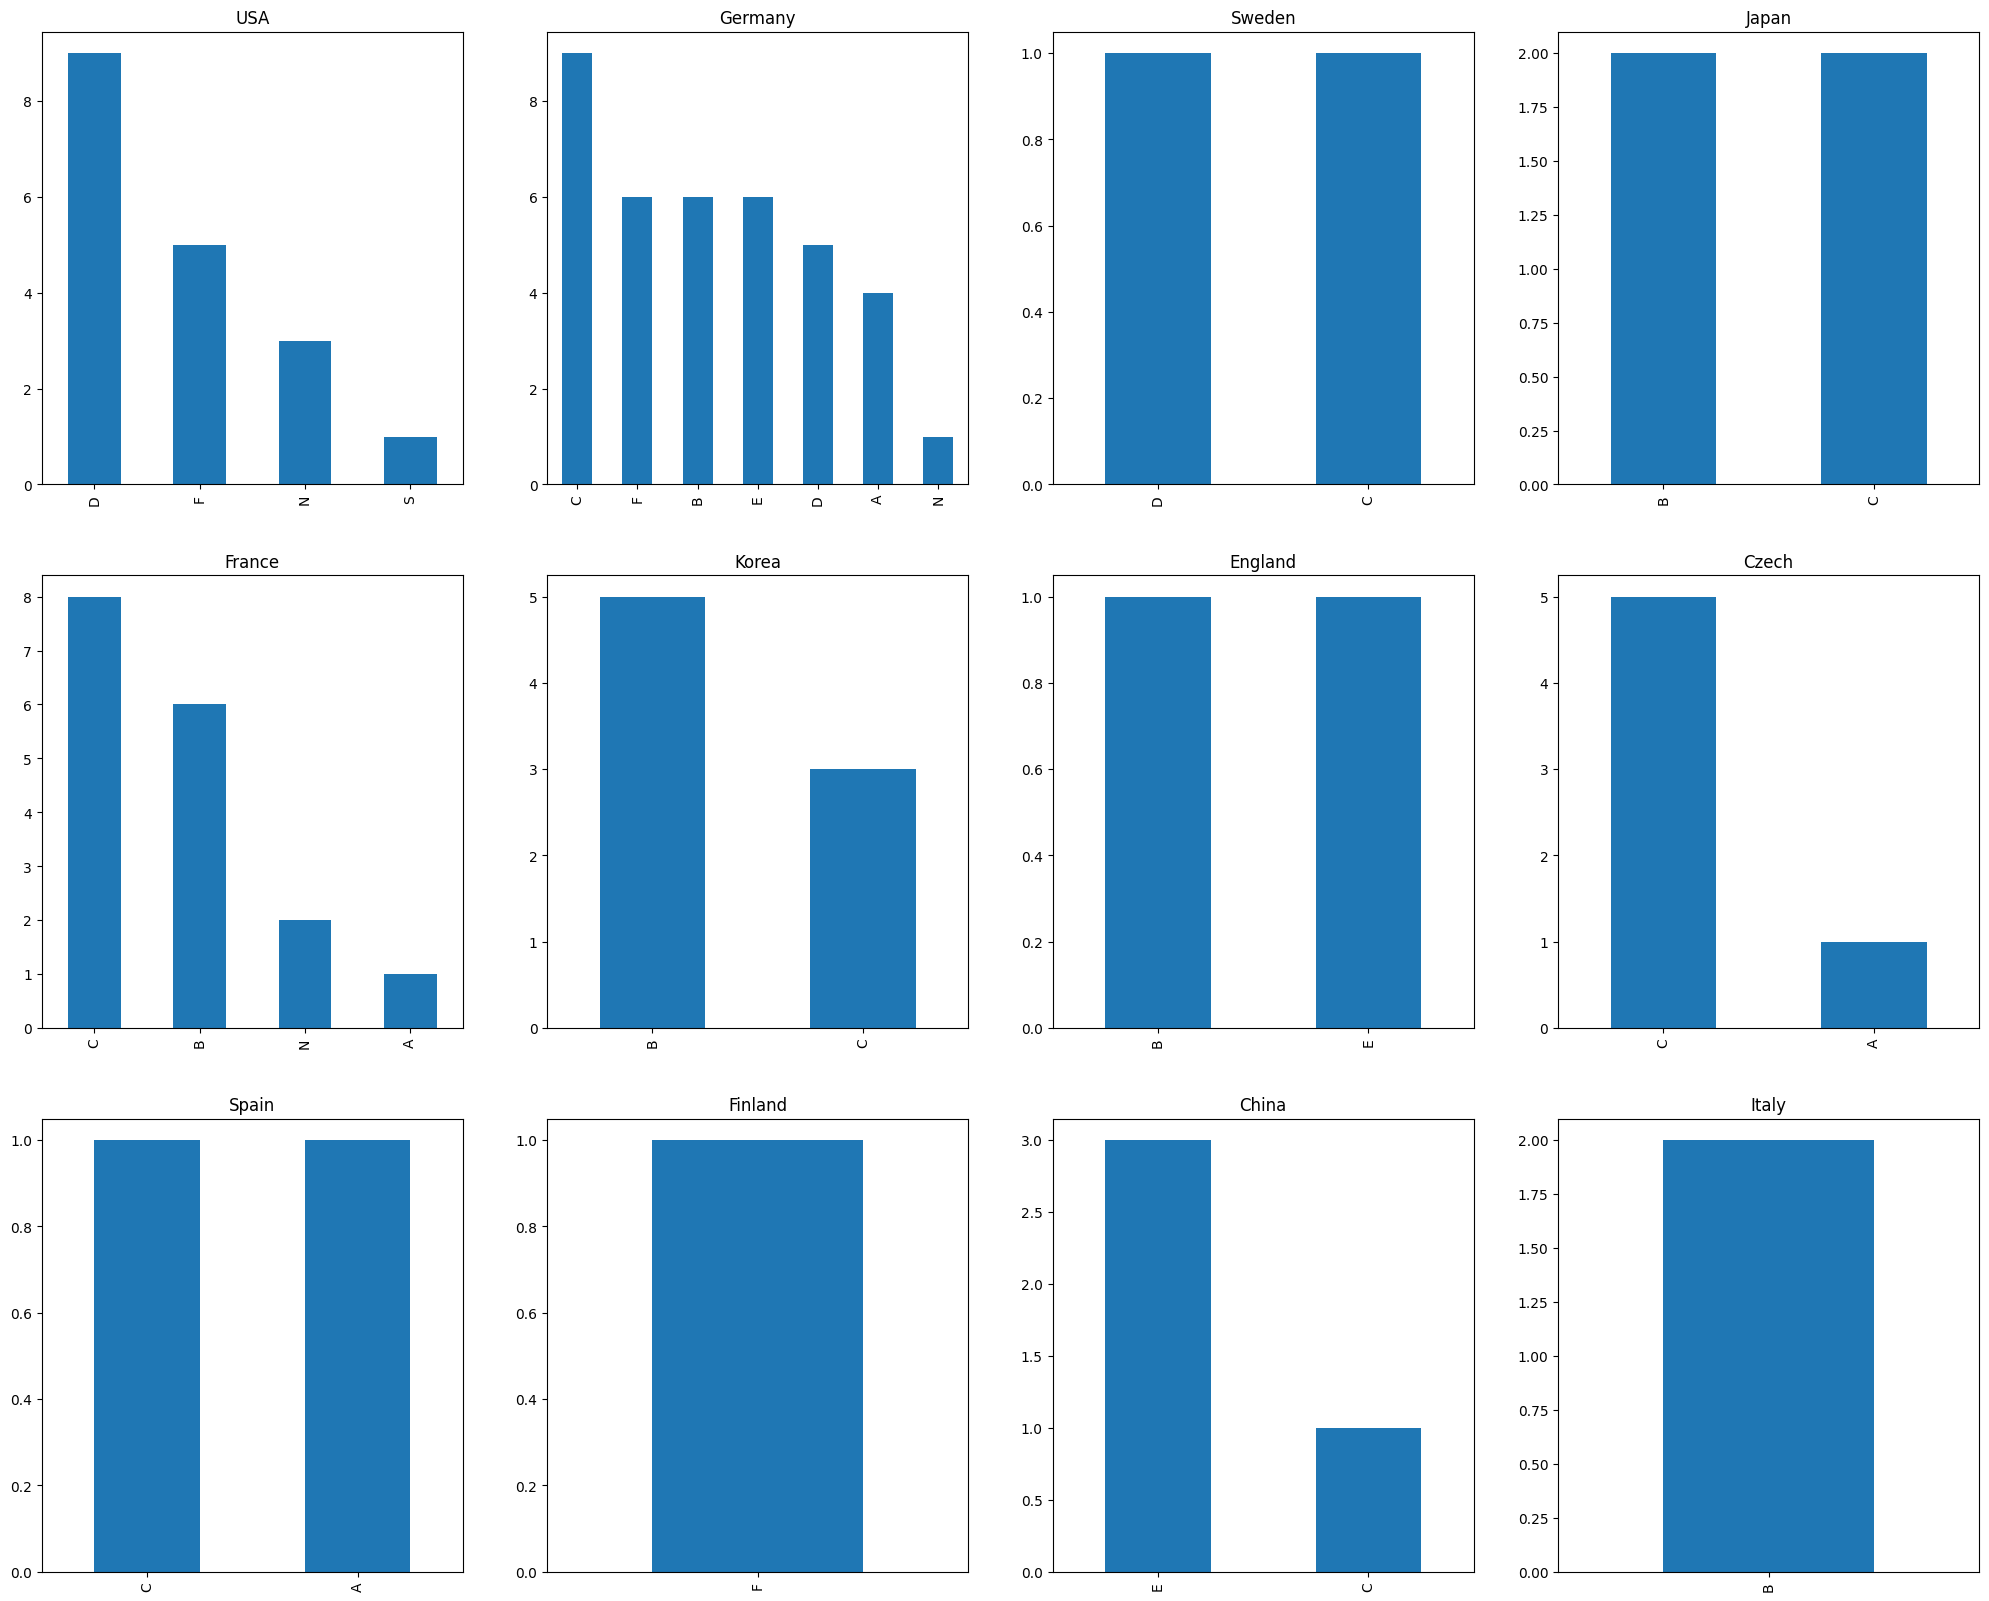

In [58]:
show_coutries_barplot('Segment')

Из графиков видим, что в США и Швецмм преобладают автомобили типа *D*. В Германии, Японии, Франции, Корее, Чехии и Испании преобладают автомобили типа *C*. В Японии, Англии и Италии преобладают автомобили типа *B*. В Финляндии преобладают автомобили типа *F*. В Китае преобладают автомобили типа *E*.

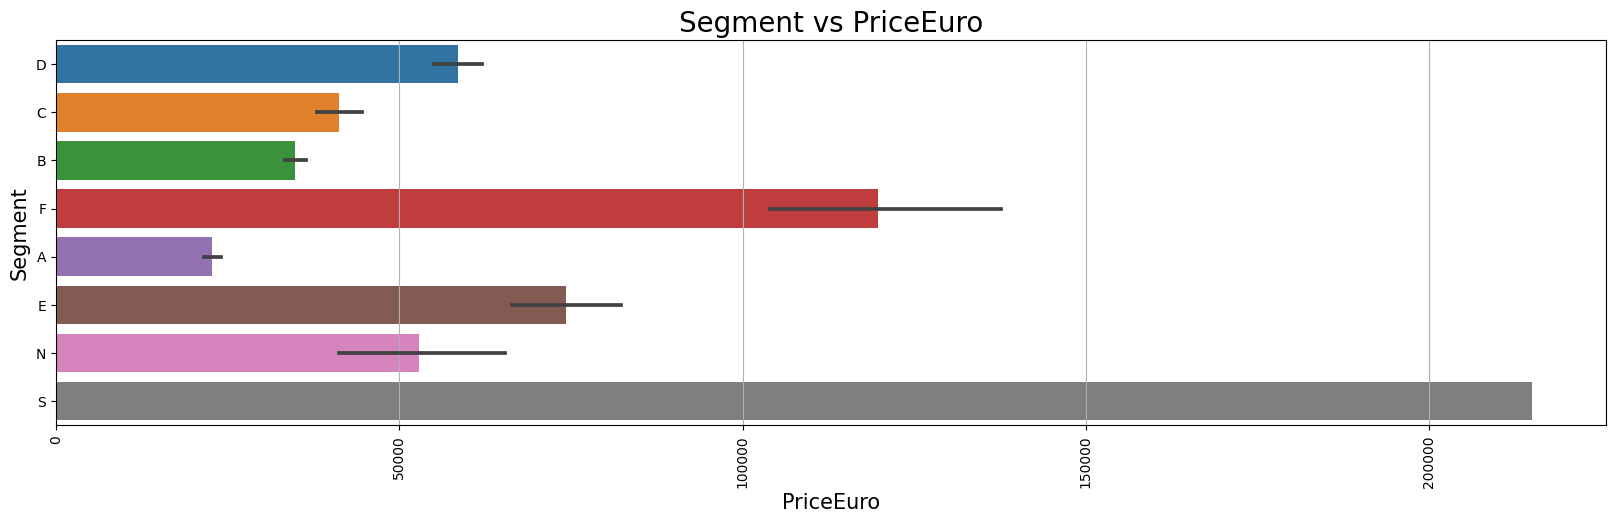

In [59]:
show_barplot("PriceEuro", "Segment")

Также можно сделать вывод, что самые дорогие электрические автомобили имеют класс *S*, а самые бюджетные --- класс *A*.

### Количественный признак Seats

Выясним, какой тип имеет признак **Seats** в датасете:

In [60]:
df['Seats'].describe()

count    103.000000
mean       4.883495
std        0.795834
min        2.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        7.000000
Name: Seats, dtype: float64

Видим, что большинство электромобилей имеет *5* сидений.

Рассмотрим графики зависимости количества сидений автомобиля от страны производителя и стоимости:

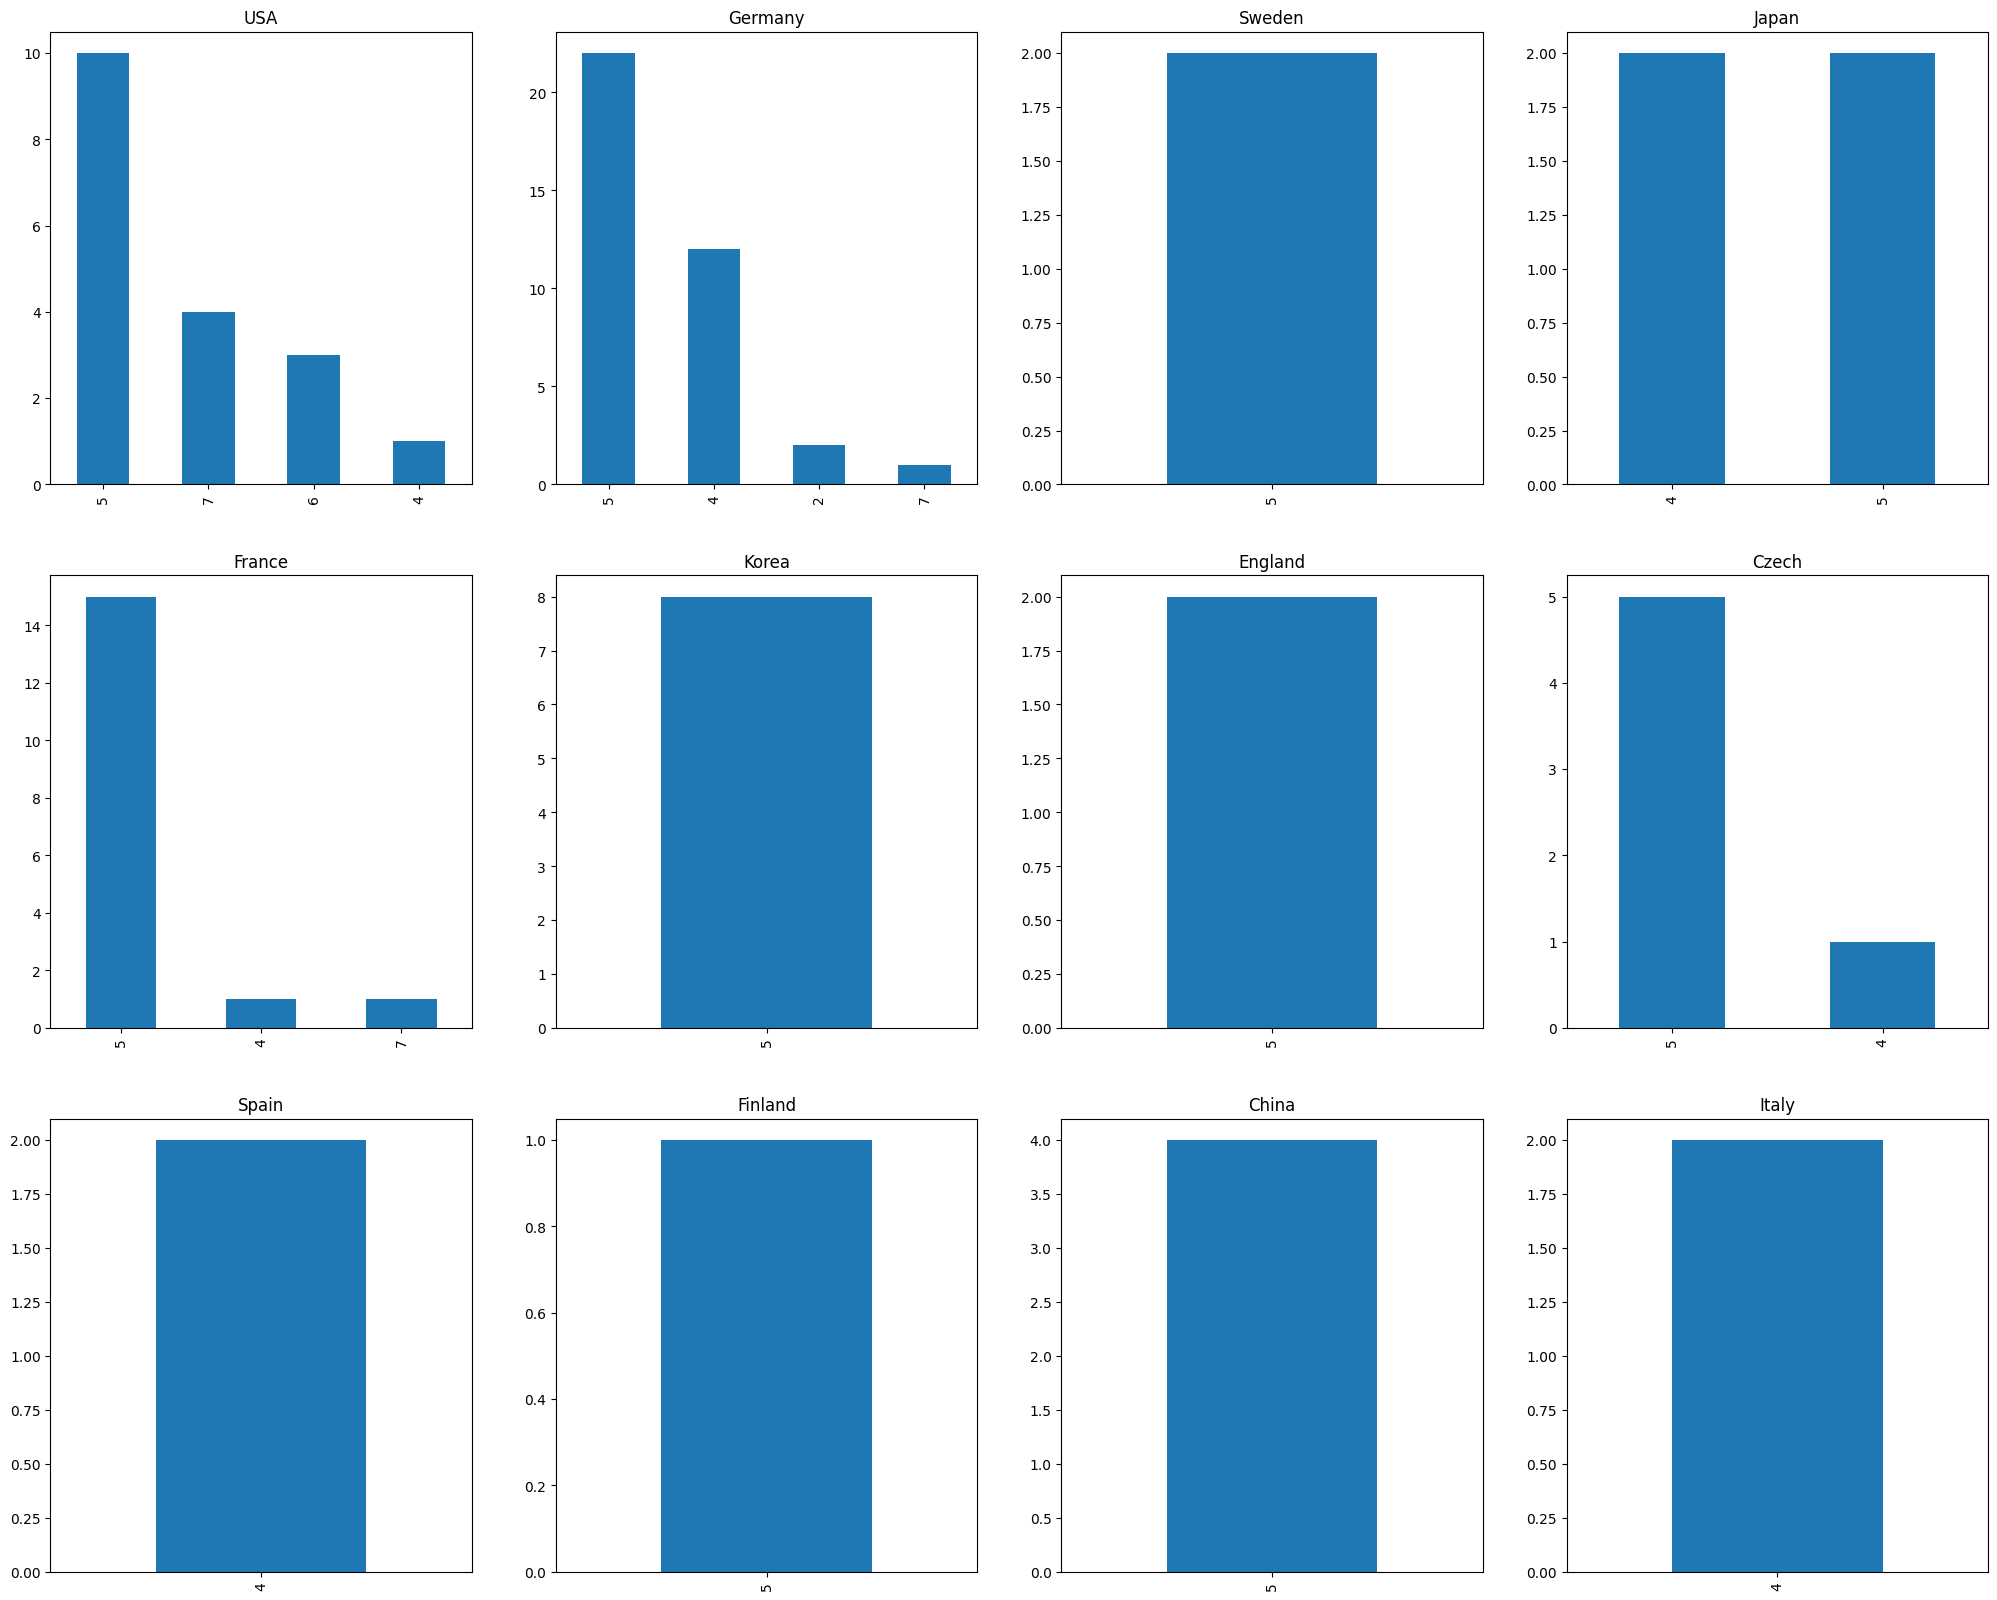

In [62]:
show_coutries_barplot('Seats')

Из графиков видим, что в США, Германии, Швеции, Франции, Корее, Англии, Чехии, Финляндии и Китае большинство электромобилей имеют *5* сидений. В Японии равное количество автомибилей с *4* и *5* сиденьями. В Италии и Испании производятся электромобили только с *4* сиденьями.

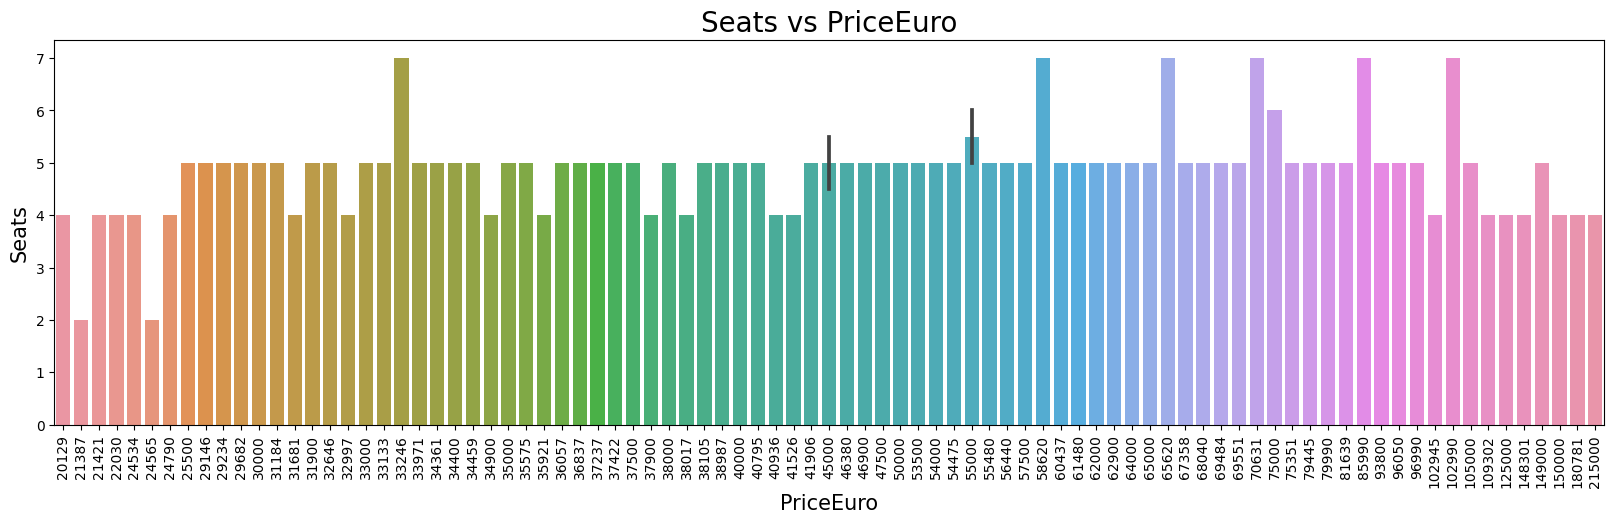

In [63]:
show_barplot("PriceEuro", "Seats")

Из графика цены и количества сидений можно сделать вывод, что самые бюджетные автомобили и самые дорогие обладают меньшим количеством сидений, чем автомобили из средней ценовой категории.